# Fold first, ask later: structure-informed function annotation of *Pseudomonas* phage proteins
## Pipeline stage 2: annotation

### Stage 2.2: annotation - single hit annotation strategies

**Goals:**
* Implement a best hit annotation method, using only the information stored in the search database.
* Implement a best annotated hit annotation method, using only the information stored in the search database.
* Assess & compare the annotation rate of best (annotated) hit methods using only database information, including Phold.
* Implement a best annotated hit annotation method, that uses information fetched from UniProt to annotate proteins.
* Assess the annotation rate of best annotated hit annotation method, that uses information fetched from UniProt to annotate proteins.
* Assess whether proteins that get annotated are different from those that do not.
* Implement a three tiered best annotated hit annotation method, and assess whether it improves annotations from the AlphaFold database.
* Implement a three tiered best annotated hit annotation method, and assess whether it improves annotations fetched through UniProt.

**Requires:**
* in folder Desktop/phage_annotation_input:
    * FoldSeek search database header files pdb_2024mar_h (FoldSeek 'PDB' database v.2024-02-20) and af50m_2024mar_h (FoldSeek 'Alphafold/UniProt50-minimal' database v.4) 
    * dict_pdb_PDBidch_UniProtID.csv : a csv file storing the dictionary linking PDB identifier & chain combinations in the FoldSeek output files (against the PDB database) to the linked UniProt identifier. Each column is one dictionary entry, the first row contains the PDB identifier & chain combination, the second row the linked UniProt ID(s)
    * dict_pdb_UniProtID_NCBIid.csv :  a csv file storing the dictionary linking UniProt IDs obtained based on the PDB identifier & chain combination in the FoldSeek output files (against the PDB database) to the NCBI id of the PROTEIN used as search query for the FoldSeek run. Each column is one dictionary entry, the first row contains the UniProt IDs, the second row the NCBI ids
    * dict_UniProtID_function.csv : a csv file storing the dictionary linking UniProt IDs to the fetched UniProt protein name. Each column is one dictionary entry, the first row contains the UniProt IDs, the second row contains the linked protein name(s).
* in folder associated_data:
    * list_obsolete_PDB_ids_15jul2024.txt : a txt file containing all the obsolete PDB identifiers at runtime (July '24)
* in folder 1_dataset/a_input/protein_overview:
    * PHAGE_protein_overview.txt : a tab-seperated overview of the NCBI proteins for each PHAGE, listing NCBI unique ID, NCBI protein name and protein length, with each row representing one NCBI protein entry
* in folder 1_dataset/b_structure/
    * in folder proteins_cluster:
        *  phage_hypothetical_clustered.tsv: MMSeqs sequence-based protein clustering output file
    * in folder structure_prediction:
        * prediction_metrics.tsv : a tab-seperated overview of the proteins for which structure prediction succeeded, summarizing protein (identifier, sequence, length) and and prediction metrics (pLDDT, MSA depth) in a protein centric fashion, where each row is one protein  
    * in folder structure_comparison:
        * in each folder batch_XX with XX a batch number between 0 and 34:
            * PROTEIN_foldseek_af50m_default.csv and PROTEIN_foldseek_pdb_default.csv : FoldSeek output file against AlphaFold/PDB database for PROTEIN which has been subjected to E-value filtering 
            * PROTEIN_foldseek_af50m_filtered.csv and PROTEIN_foldseek_pdb_filtered.csv : FoldSeek output file against AlphaFold/PDB database for PROTEIN which has been subjected to filtering based on E-value, SCOP class probability, pLDDT aligned region and alignment quality
* in folder a_pharokka:
    * in folders output_batch_XX with XX the batch number:
        * Pharokka protein output (see Pharokka docs for more information on the file formats and generated outputs):
            * pharokka_proteins_summary_output.tsv
* in folder b_phold:
    * in folders output_compare_str_batch_XX with XX the batch number (see Phold docs for more information on the file formats and generated outputs):
        * phold_per_cds_predictions.tsv

**Generates:**
* best_hit_annotations.tsv: tab seperated file storing the results of best hit annotation method, with two rows per protein (1 for results against the PDB, 1 for results against the AlphaFold database).
* best_annotated_hit_annotations.tsv: tab seperated file storing the results of best annotated hit annotation method, with two rows per protein (1 for results against the PDB, 1 for results against the AlphaFold database).
* best_annotated_hit_uniprot_annotations.tsv : tab seperated file storing the results of best annotated hit annotation method using protein annotations from UniProt, with two rows per protein (1 for results against the PDB, 1 for results against the AlphaFold database).
* best_annotated_hit_threetiers_annotations.tsv : tab seperated file storing the results of best annotated hit annotation method using three tiers of annotation quality classification, with one rows per protein (only results against the AlphaFold database).
* best_annotated_hit_uniprot_threetiers_annotations : tab seperated file storing the results of best annotated hit annotation method using three tiers of annotation quality classification and protein annotations from UniProt, with two rows per protein (1 for results against the PDB, 1 for results against the AlphaFold database).

#### General settings, imports, variables and environments

Conda environment: ffal_annotate

Created with `conda create -n ffal_annotate`. Then installed `jupyter notebook`, `pandas` through conda & `seaborn`, `scipy`, `matplotlib-venn`, `UpSetPlot`, `biopython` through pip (commands executed in notebook Code_annotation_background.ipynb).

In [ ]:
!pip install seaborn

In [ ]:
!pip install scipy

In [ ]:
!pip install matplotlib-venn

In [ ]:
!pip install UpSetPlot

In [ ]:
!pip install biopython

In [1]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
# created-by: conda 24.11.3
@EXPLICIT
https://conda.anaconda.org/conda-forge/noarch/ca-certificates-2025.6.15-h4c7d964_0.conda
https://conda.anaconda.org/conda-forge/win-64/intel-openmp-2024.2.1-h57928b3_1083.conda
https://conda.anaconda.org/conda-forge/noarch/python_abi-3.13-7_cp313.conda
https://conda.anaconda.org/conda-forge/noarch/tzdata-2025b-h78e105d_0.conda
https://conda.anaconda.org/conda-forge/win-64/ucrt-10.0.22621.0-h57928b3_1.conda
https://conda.anaconda.org/conda-forge/win-64/winpty-0.4.3-4.tar.bz2
https://conda.anaconda.org/conda-forge/win-64/libwinpthread-12.0.0.r4.gg4f2fc60ca-h57928b3_9.conda
https://conda.anaconda.org/conda-forge/win-64/vc14_runtime-14.44.35208-h818238b_26.conda
https://conda.anaconda.org/conda-forge/win-64/vc-14.3-h41ae7f8_26.conda
https://conda.anaconda.org/conda-forge/win-64/vs2015_runtime-14.44.35208-h38c0c73_26.conda
https://

In [2]:
# imports
import csv
import json
import os
import random
import re
import requests
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Bio

from Bio.PDB import *
from json.decoder import JSONDecodeError
from scipy.stats import mannwhitneyu
from upsetplot import plot

In [3]:
 # settings for requests
sess = requests.Session()
adapter = requests.adapters.HTTPAdapter(max_retries = 10)
sess.mount("https://", adapter)

In [4]:
# clear reference to different directories
pipeline_annot_dir = os.getcwd()
pipeline_search_dir = os.path.join(pipeline_annot_dir, os.pardir, "1_dataset")
master_dir = os.path.abspath(os.path.join(pipeline_annot_dir, os.pardir, os.pardir))
data_dir = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop', 'phage_annotation_input')
struct_out_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_prediction") 
comp_out_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_comparison") 

In [5]:
# overview of proteins, batches, and issues
    # cluster data
cluster_protein_match = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster", "phage_hypothetical_clustered.tsv"), 
                                    sep="\t", header=None, names=["cluster_rep","cluster_member"])
all_cluster_reps = list(cluster_protein_match["cluster_rep"].unique())
    # issues with structure prediciton
bug_ids = [1024212698, 1049307970, 937263666, 937263657, 2095861127, 2476109552, 1201093646, 1278230276,
          82657980, 1269167545, 2080079782, 1899050855, 2422010414, 701904370, 1009089253, 2416396857, 1825586694]
relaxation_failed_ids = [585865431, 985788839, 656178049, 985788835, 2512621507, 985789034, 985789035, 985788870, 985788822, 985788825,
                        985788820, 985788821, 985788819, 936761474, 985788892, 985788800, 985788799, 2512621457, 985788846, 1562103688,
                        985788845, 2095887196, 1808209948, 1832334352, 2250993998, 2512621472, 1562103654, 985788861]
    # proteins with predicted structures
proteins_w_structure = list(set(all_cluster_reps) - set(bug_ids))

In [6]:
# linking batches and proteins for the structure comparison files
dict_batch_comp_prot = {}
dict_batch_comp = {}
for protein in proteins_w_structure:
    for index_batch in range(0,35):
        batch_dir = os.path.join(comp_out_dir, f"batch_{index_batch}", f"batch_{index_batch}")
        if os.path.isfile(os.path.join(batch_dir, f"{protein}_foldseek_af50m_default.csv")) and os.path.isfile(os.path.join(batch_dir, f"{protein}_foldseek_pdb_default.csv")):
            dict_batch_comp_prot[protein] = index_batch
for key, value in dict_batch_comp_prot.items():
    if value in dict_batch_comp:
        dict_batch_comp[value].append(key)
    else:
        dict_batch_comp[value] = [key]
dict_batch_comp = dict(sorted(dict_batch_comp.items()))

#### Goal 1 : Implement and assess a best hit annotation method, using only the information stored in the search database.

As a first annotation strategy, we will implement a best hit method, using the information stored in the search database headers to annotate the proteins.

In [7]:
# dir to store results
one_hit_dir = os.path.join(pipeline_annot_dir, "c_single_hit_annotations")

In [ ]:
os.mkdir(one_hit_dir)

##### Prerequisites: FoldSeek output files + FoldSeek database headers

In [8]:
# function returning the FoldSeek files for a protein in a batch
# reading in the FoldSeek output files for a specific protein in a batch
def read_foldseek_protein(batch_num, protein):
    batch_dir = os.path.join(comp_out_dir, f"batch_{batch_num}", f"batch_{batch_num}")
    pdb_fil = os.path.join(batch_dir, f"{protein}_foldseek_pdb_filtered.csv")
    af50m_fil = os.path.join(batch_dir, f"{protein}_foldseek_af50m_filtered.csv")
    try: 
        df_pdb_fil = pd.read_csv(pdb_fil)
        df_af50m_fil = pd.read_csv(af50m_fil)
        return df_pdb_fil, df_af50m_fil
    except FileNotFoundError:
        print(f"issue for {batch} protein {protein}.")

In [9]:
# read in the protein annotation data - PDB database
pdbid_descr_db = {}
with open(os.path.join(data_dir, "pdb_2024mar_h")) as file:
    for line in file:
        if len(line.strip()) != 0 :
            pdb_id = line.split()[0].removeprefix("\x00")
            descr = " ".join(line.split()[1:])
            pdbid_descr_db[pdb_id] = descr

In [10]:
 # read in the protein annotation data - AF50m database
af50mid_descr_db = {}
with open(os.path.join(data_dir, "af50m_2024mar_h")) as fp:
    for line in fp:
        if len(line.strip()) != 0 :
            af_id = line.split()[0].removeprefix("\x00")
            descr = " ".join(line.split()[1:])
            af50mid_descr_db[af_id] = descr

##### Code for annotation using a best hit method, using only the information stored in the search databases

Let's write some code to annotate a protein using its best FoldSeek hit, immediately including a tag about whether this is actually a useful annotation or not. 

For the PDB, after some exploration, we've settled on the following filter for labelling an annotation as non-annotation:

In [11]:
# function for filter
def is_likely_hypothetical_pdb(descr):
    if ("unknown" in descr.lower()) and ("function" in descr.lower()):
        return True
    else:
        return False

In [12]:
# for PDB, the keyword 'unknown' combined with 'function' seems to be reasonable 
    # as illustrated to random annotations that we would consider unannotated
unannotated_pdb = list()
for key, value in pdbid_descr_db.items():
    if ("unknown" in value) and ("function" in value):
        unannotated_pdb.append((key, value))
print(random.sample(unannotated_pdb, 20))

[('1nmp.cif.gz_B', 'Structural genomics, ybgI protein, unknown function'), ('3iuk.cif.gz_A', 'Crystal structure of putative bacterial protein of unknown function (DUF885, PF05960.1, ) from Arthrobacter aurescens TC1, reveals fold similar to that of M32 carboxypeptidases'), ('3m05.cif.gz_C', 'The crystal structure of a functionally unknown protein PEPE_1480 from Pediococcus pentosaceus ATCC 25745'), ('3ez0.cif.gz_B', 'Crystal structure of protein of unknown function with ferritin-like fold (YP_832262.1) from Arthrobacter sp. FB24 at 2.33 A resolution'), ('3lag.cif.gz_A', 'The crystal structure of a functionally unknown protein RPA4178 from Rhodopseudomonas palustris CGA009'), ('3fh1.cif.gz_A', 'Crystal structure of a ntf2-like protein of unknown function (mll8193) from mesorhizobium loti at 1.60 A resolution'), ('2wam.cif.gz_A', 'Crystal structure of Mycobacterium tuberculosis unknown function protein Rv2714'), ('2kke.cif.gz_MODEL_8_A', 'Solution NMR Structure of a dimeric protein of un

In [13]:
# let's implement this in a function, 
    # returning the description of the first hit, and whether or not this description is an informative annotation
def find_first_annotation_foldseek_pdb(dataframe):
    target = dataframe.at[0, "target"]
    best_ann = pdbid_descr_db.get(target)
    annotation_found = not is_likely_hypothetical_pdb(best_ann)
    return best_ann, annotation_found

For the AlphaFold database, three rounds of manual inspection of annotations led to the following REGEXes for filtering out uninformative annotations, in the context of phage proteins:

In [14]:
# final filter lists
hypothetical_af_search = ["whole genome shotgun sequence"] 
hypothetical_af_match = ["unnamed product", 
                         r"genome assembly, chromosome: [\w+]+", r"str. [\w+]+[\d+]+", 
                         "protein of unknwon function", 
                         "conserved domain protein, histidine-rich", r"lin[\d+]+ protein", r"orf[\w+]+( domain-containing)?( protein)?", 
                         "phage related-protein", "phage d3 protein", 
                         r"dna, contig(: [\w+]+)?", r"uncharacterized protein conserved in bacteria(, prophage-related)?", r"gene [\d+]+ protein",
                         r"gifsy-[\d+] prophage protein", r"(hypothetical )?genomic island protein",
                         r"(putative )?(conserved )?(\([a-z ]+\) )?((uncharacterized)|(hypothet(h)?ical)|(unannotated))( conserved)?( protein)?(, (pro)?phage-related)?(, isoform [AB])?",
                         r"(predicted|unannotated|uncharacterized|hypothetical|putative( |_)?)?(expressed)?(conserved)?((mobile element)|(integron protein cassette))?(( )?domain)?(constituent)?([\d+]+)?( |_)protein(_-_conserved)?", 
                         r"((hypothetical|putative|probable|conserved|uncharacterized) )?((hypothetical|putative|probable|conserved|uncharacterized) )?(bacterio|pro)?(phage)((-| )(like|related|associated))?( (hypothetical|putative|probable|conserved|uncharacterized))?( protein)?(,? [g]?p[\d+]+\b)?(, family)?(, putative)?",
                         r"hk97( family)?( phage)? protein", r"putative similar to (bacterio)?phage protein",
                         r"(putative )?uncharacterized protein(?! duf[\d+]+)( \w+)?", 
                         r"(phage( |-))?(protein )?(putative )?[g]?p[\d+]+\b(-like)?( domain(-containing)?)?(( |-)family)?( protein)?"
                        ]

In [15]:
# functions to check whether description is in the list of hypothetical protein annotations for AFdb annotations
def is_hypothetical_af(descr):
    hypothetical_label = False
    for filter_descr_s in hypothetical_af_search:
        if re.search(filter_descr_s, descr.strip().lower()) != None:
            hypothetical_label = True
    for filter_descr_m in hypothetical_af_match:
        if re.fullmatch(filter_descr_m, descr.strip().lower()) != None:
            hypothetical_label = True
    return hypothetical_label

In [16]:
# let's implement this in a function, 
    # returning the description of the first hit, and whether or not this description is an informative annotation
def find_first_annotation_foldseek_afdb(dataframe):
    target = dataframe.at[0, "target"]
    best_ann = af50mid_descr_db.get(target)
    annotation_found = not is_hypothetical_af(best_ann)
    return best_ann, annotation_found

In [ ]:
# let's write the results to file
file = open(os.path.join(one_hit_dir, "best_hit_annotations.tsv"), "w")
file.write(f"protein\tpdb/af50m\tempty\tbest_ann\tannotation_found\n")
for batch, protein_set in dict_batch_comp.items():
    for protein in protein_set:
        pdb_fil, af50m_fil = read_foldseek_protein(batch, protein)
        if pdb_fil.empty:
            file.write(f"{protein}\tpdb\tTrue\tNA\tNA\n")
        if not pdb_fil.empty:
            pdb_fil = pdb_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_first_annotation_foldseek_pdb(pdb_fil)
            file.write(f"{protein}\tpdb\tFalse\t{best_ann}\t{annotation_found}\n")
        if af50m_fil.empty:
            file.write(f"{protein}\taf50m\tTrue\tNA\tNA\n")
        if not af50m_fil.empty:
            af50m_fil = af50m_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_first_annotation_foldseek_afdb(af50m_fil)
            file.write(f"{protein}\taf50m\tFalse\t{best_ann}\t{annotation_found}\n")
file.close()

#### Goal 2 : Implement and assess a best annotated hit annotation method, using only the information stored in the search database.

As a second annotation strategy, we will implement a best annotated hit method (such as implemented in Phold), using the information stored in the search database headers to annotate the proteins.

##### Code annotation using a best annotated hit method, using only the information stored in the search databases

To do so, we have to update the function that is used to go through the the FoldSeek output files.

In [17]:
# updated PDB hit analysis method
def find_best_annotation_foldseek_pdb(dataframe):
    annotation_found = False
    for i in range(0, len(dataframe)):
        target = dataframe.at[i, "target"]
        descr = pdbid_descr_db.get(target)
        # get top annotation that is not likely hypothetical
        if is_likely_hypothetical_pdb(descr) == False:
            annotation_found = True
            best_ann = descr
            break
    # if all annotations are hypothetical, the flag annotation found remains false
        # if this is the case, we just pick the highest ranked annotation
    if annotation_found == False:
        best_ann = pdbid_descr_db.get(dataframe.at[0, "target"])
    return best_ann, annotation_found

In [18]:
# updated PDB hit analysis method
def find_best_annotation_foldseek_afdb(dataframe):
    annotation_found = False
    for i in range(0, len(dataframe)):
        target = dataframe.at[i, "target"]
        descr = af50mid_descr_db.get(target)
        # get top annotation that is not likely hypothetical
        if is_hypothetical_af(descr) == False:
            annotation_found = True
            best_ann = descr
            break
    # if all annotations are hypothetical, the flag annotation found remains false
        # if this is the case, we just pick the highest ranked annotation
    if annotation_found == False:
        best_ann = pdbid_descr_db.get(dataframe.at[0, "target"])
    return best_ann, annotation_found

In [ ]:
# let's write the results to file
file = open(os.path.join(one_hit_dir, "best_annotated_hit_annotations.tsv"), "w")
file.write(f"protein\tpdb/af50m\tempty\tbest_ann\tannotation_found\n")
for batch, protein_set in dict_batch_comp.items():
    for protein in protein_set:
        pdb_fil, af50m_fil = read_foldseek_protein(batch, protein)
        if pdb_fil.empty:
            file.write(f"{protein}\tpdb\tTrue\tNA\tNA\n")
        if not pdb_fil.empty:
            pdb_fil = pdb_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_best_annotation_foldseek_pdb(pdb_fil)
            file.write(f"{protein}\tpdb\tFalse\t{best_ann}\t{annotation_found}\n")
        if af50m_fil.empty:
            file.write(f"{protein}\taf50m\tTrue\tNA\tNA\n")
        if not af50m_fil.empty:
            af50m_fil = af50m_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_best_annotation_foldseek_afdb(af50m_fil)
            file.write(f"{protein}\taf50m\tFalse\t{best_ann}\t{annotation_found}\n")
file.close()

#### Goal 3 : Assess & compare the annotation rate of best (annotated) hit methods using only database information, including Phold.

Let's compare the annotation rates of the best (annotated) hit methods and Phold. To allow for a fair comparison, we will treat the protein clusters that could be annotated through Pharokka and the truly unannotated protein clusters seperately. Moreover, we will also include statistics on how many of the protein clusters even had any database hits to begin with. 

Let's start by reading in the different annotation results:

In [19]:
phold_results_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_output", "5_phold") 

In [20]:
# aggregating phold - structure results
phold_structure_df = pd.DataFrame()
    # loop over batch
for i in range(0,21):
    batch = f"batch_{i}"
    batch_file = pd.read_csv(os.path.join(phold_results_dir, f"output_compare_str_{batch}", "phold_per_cds_predictions.tsv"), sep = "\t")
    phold_structure_df = pd.concat([batch_file, phold_structure_df], ignore_index = True) 

In [21]:
best_hit_db_df = pd.read_csv(os.path.join(one_hit_dir, "best_hit_annotations.tsv"), sep = "\t")

In [22]:
best_ann_hit_db_df = pd.read_csv(os.path.join(one_hit_dir, "best_annotated_hit_annotations.tsv"), sep = "\t")

Let's combine this information per database & supplement it with whether or not protein clusters were annotated with Pharokka.

In [23]:
pdb_ann = pd.merge(best_hit_db_df[best_hit_db_df["pdb/af50m"] == "pdb"], best_ann_hit_db_df[best_ann_hit_db_df["pdb/af50m"] == "pdb"], on = ["protein", "pdb/af50m", "empty"], suffixes = ("_bh", "_bah"))
afdb_ann = pd.merge(best_hit_db_df[best_hit_db_df["pdb/af50m"] == "af50m"], best_ann_hit_db_df[best_ann_hit_db_df["pdb/af50m"] == "af50m"], on = ["protein", "pdb/af50m", "empty"], suffixes = ("_bh", "_bah"))

In [24]:
# reading in Pharokka annotation information
pharokka_results_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_output", "4_pharokka") 
pharokka_df = pd.DataFrame()
for i in range(0,21):
    batch = f"batch_{i}"
    batch_file = pd.read_csv(os.path.join(pharokka_results_dir, f"output_{batch}", "pharokka_proteins_summary_output.tsv"), sep = "\t")
    pharokka_df = pd.concat([batch_file, pharokka_df], ignore_index = True)
# extracting the NCBI UIDs of annotated proteins
protein_id_ann = list(pharokka_df[(pharokka_df["category"] != "unknown function")]["ID"])
ncbi_id_ann = [int(prot.removeprefix("protein_")) for prot in protein_id_ann]

In [25]:
# adding a column to store information on Pharokka annotation
pdb_ann["pharokka_ann"] = False
pdb_ann.loc[pdb_ann["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True
afdb_ann["pharokka_ann"] = False
afdb_ann.loc[afdb_ann["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True
phold_structure_df["protein"] = phold_structure_df["cds_id"].str.removeprefix("protein_").astype(int)
phold_structure_df["pharokka_ann"] = False
phold_structure_df.loc[phold_structure_df["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True

##### Subset of clusters annotated by Pharokka

Let's have a look per database (PDB, AFdb) and method (Phold, BH, BAH) at the annotation rates, for proteins annotated by Pharokka (should be the 'easy set').

In [26]:
num_tba_p = len(ncbi_id_ann) # the total number of protein clusters that was annotated by Pharokka

In [27]:
# PDB database statistics
pdb_ann_phar = pdb_ann[pdb_ann["pharokka_ann"] == True]
pdb_ann_phar_match = pdb_ann_phar[pdb_ann_phar["empty"] == False]
pdb_ann_phar_match_bh_ann = pdb_ann_phar_match[pdb_ann_phar_match["annotation_found_bh"] == True]
pdb_ann_phar_match_bh_unann = pdb_ann_phar_match[pdb_ann_phar_match["annotation_found_bh"] == False]
pdb_ann_phar_match_bah_ann = pdb_ann_phar_match[pdb_ann_phar_match["annotation_found_bah"] == True]
pdb_ann_phar_match_bah_unann = pdb_ann_phar_match[pdb_ann_phar_match["annotation_found_bah"] == False]
    # number of Pharokka annotated clusters with no match against PDB
num_pdb_ann_phar_nomatch = len(pdb_ann_phar[pdb_ann_phar["empty"] == True]) 
    # percentage of Pharokka annotated clusters with no match against PDB
per_pdb_ann_phar_nomatch = "{:.2f}".format(num_pdb_ann_phar_nomatch*100/num_tba_p)
    # number of Pharokka annotated clusters with annotated match (BH method)
num_pdb_ann_phar_match_bh_ann = len(pdb_ann_phar_match_bh_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BH
per_pdb_ann_phar_bh_ann = "{:.2f}".format(num_pdb_ann_phar_match_bh_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BH
per_pdb_ann_phar_match_bh_ann = "{:.2f}".format(num_pdb_ann_phar_match_bh_ann*100/(num_tba_p-num_pdb_ann_phar_nomatch)) 
    # number of Pharokka annotated clusters with annotated match (BH method)
num_pdb_ann_phar_match_bh_unann = len(pdb_ann_phar_match_bh_unann) 
    # number of Pharokka annotated clusters with annotated match (BAH method)
num_pdb_ann_phar_match_bah_ann = len(pdb_ann_phar_match_bah_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BAH
per_pdb_ann_phar_bah_ann = "{:.2f}".format(num_pdb_ann_phar_match_bah_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BAH
per_pdb_ann_phar_match_bah_ann = "{:.2f}".format(num_pdb_ann_phar_match_bah_ann*100/(num_tba_p-num_pdb_ann_phar_nomatch)) 
    # number of Pharokka annotated clusters with unannotated match (BAH method)
num_pdb_ann_phar_match_bah_unann = len(pdb_ann_phar_match_bah_unann)  
print(f"Statistics of annotation using the PDB database:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_p-num_pdb_ann_phar_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_phar_nomatch}")
print(f"------------------------------------------------")
print(f"Best hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_phar_match_bh_ann} ({per_pdb_ann_phar_match_bh_ann}% of all those with matches, {per_pdb_ann_phar_bh_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_phar_match_bh_unann + num_pdb_ann_phar_nomatch} ({num_pdb_ann_phar_nomatch} due to no matches)")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_phar_match_bah_ann} ({per_pdb_ann_phar_match_bah_ann}% of all those with matches, {per_pdb_ann_phar_bah_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_phar_match_bah_unann + num_pdb_ann_phar_nomatch} ({num_pdb_ann_phar_nomatch} due to no matches)")

Statistics of annotation using the PDB database:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 1337
    Number of clusters without matches: 1498
------------------------------------------------
Best hit annotation method:
    Number of clusters with annotations: 1316 (98.43% of all those with matches, 46.42% of all Pharokka annotated clusters)
    Number of clusters without annotations: 1519 (1498 due to no matches)
Best annotated hit annotation method:
    Number of clusters with annotations: 1325 (99.10% of all those with matches, 46.74% of all Pharokka annotated clusters)
    Number of clusters without annotations: 1510 (1498 due to no matches)


In [28]:
# AlphaFold database statistics
afdb_ann_phar = afdb_ann[afdb_ann["pharokka_ann"] == True]
afdb_ann_phar_match = afdb_ann_phar[afdb_ann_phar["empty"] == False]
afdb_ann_phar_match_bh_ann = afdb_ann_phar_match[afdb_ann_phar_match["annotation_found_bh"] == True]
afdb_ann_phar_match_bh_unann = afdb_ann_phar_match[afdb_ann_phar_match["annotation_found_bh"] == False]
afdb_ann_phar_match_bah_ann = afdb_ann_phar_match[afdb_ann_phar_match["annotation_found_bah"] == True]
afdb_ann_phar_match_bah_unann = afdb_ann_phar_match[afdb_ann_phar_match["annotation_found_bah"] == False]
    # number of Pharokka annotated clusters with no match against AlphaFold database
num_afdb_ann_phar_nomatch = len(afdb_ann_phar[afdb_ann_phar["empty"] == True]) 
    # percentage of Pharokka annotated clusters with no match against AlphaFold database
per_afdb_ann_phar_nomatch = "{:.2f}".format(num_afdb_ann_phar_nomatch*100/num_tba_p)
    # number of Pharokka annotated clusters with annotated match (BH method)
num_afdb_ann_phar_match_bh_ann = len(afdb_ann_phar_match_bh_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BH
per_afdb_ann_phar_bh_ann = "{:.2f}".format(num_afdb_ann_phar_match_bh_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BH
per_afdb_ann_phar_match_bh_ann = "{:.2f}".format(num_afdb_ann_phar_match_bh_ann*100/(num_tba_p-num_afdb_ann_phar_nomatch)) 
    # number of Pharokka annotated clusters with annotated match (BH method)
num_afdb_ann_phar_match_bh_unann = len(afdb_ann_phar_match_bh_unann) 
    # number of Pharokka annotated clusters with annotated match (BAH method)
num_afdb_ann_phar_match_bah_ann = len(afdb_ann_phar_match_bah_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BAH
per_afdb_ann_phar_bah_ann = "{:.2f}".format(num_afdb_ann_phar_match_bah_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_phar_match_bah_ann = "{:.2f}".format(num_afdb_ann_phar_match_bah_ann*100/(num_tba_p-num_afdb_ann_phar_nomatch)) 
    # number of Pharokka annotated clusters with unannotated match (BAH method)
num_afdb_ann_phar_match_bah_unann = len(afdb_ann_phar_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_p-num_afdb_ann_phar_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_phar_nomatch}")
print(f"------------------------------------------------")
print(f"Best hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_phar_match_bh_ann} ({per_afdb_ann_phar_match_bh_ann}% of all those with matches, {per_afdb_ann_phar_bh_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_phar_match_bh_unann + num_afdb_ann_phar_nomatch} ({num_afdb_ann_phar_nomatch} due to no matches)")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_phar_match_bah_ann} ({per_afdb_ann_phar_match_bah_ann}% of all those with matches, {per_afdb_ann_phar_bah_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_phar_match_bah_unann + num_afdb_ann_phar_nomatch} ({num_afdb_ann_phar_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 2577
    Number of clusters without matches: 258
------------------------------------------------
Best hit annotation method:
    Number of clusters with annotations: 939 (36.44% of all those with matches, 33.12% of all Pharokka annotated clusters)
    Number of clusters without annotations: 1896 (258 due to no matches)
Best annotated hit annotation method:
    Number of clusters with annotations: 2277 (88.36% of all those with matches, 80.32% of all Pharokka annotated clusters)
    Number of clusters without annotations: 558 (258 due to no matches)


In [29]:
# Phold statistics
phold_ann_phar = phold_structure_df[phold_structure_df["pharokka_ann"] == True]
phold_ann_phar_match = phold_ann_phar[phold_ann_phar["annotation_source"] == "foldseek"]
phold_ann_phar_match_bah_ann = phold_ann_phar_match[phold_ann_phar_match["function"] != "unknown function"]
phold_ann_phar_match_bah_unann = phold_ann_phar_match[phold_ann_phar_match["function"] == "unknown function"]
    # number of Pharokka annotated clusters with no match against Phold databases
num_phold_ann_phar_nomatch = len(phold_ann_phar[phold_ann_phar["annotation_source"] != "foldseek"]) 
    # percentage of Pharokka annotated clusters with no match against Phold databases
per_phold_ann_phar_nomatch = "{:.2f}".format(num_phold_ann_phar_nomatch*100/num_tba_p)
    # number of Pharokka annotated clusters with annotated match (BAH method)
num_phold_ann_phar_match_bah_ann = len(phold_ann_phar_match_bah_ann) 
    # of the Pharokka annotated clusters, which percentage gets annotated using BAH
per_phold_ann_phar_bah_ann = "{:.2f}".format(num_phold_ann_phar_match_bah_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BAH
per_phold_ann_phar_match_bah_ann = "{:.2f}".format(num_phold_ann_phar_match_bah_ann*100/(num_tba_p-num_phold_ann_phar_nomatch)) 
    # number of Pharokka annotated clusters with unannotated match (BAH method)
num_phold_ann_phar_match_bah_unann = len(phold_ann_phar_match_bah_unann)  
print(f"Statistics of annotation using Phold:")
print(f"------------------------------------------------")
print(f"Matches against the Phold databases:")
print(f"    Number of clusters with matches: {num_tba_p-num_phold_ann_phar_nomatch}")
print(f"    Number of clusters without matches: {num_phold_ann_phar_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_phold_ann_phar_match_bah_ann} ({per_phold_ann_phar_match_bah_ann}% of all those with matches, {per_phold_ann_phar_bah_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_phold_ann_phar_match_bah_unann+num_phold_ann_phar_nomatch} ({num_phold_ann_phar_nomatch} due to no matches)")

Statistics of annotation using Phold:
------------------------------------------------
Matches against the Phold databases:
    Number of clusters with matches: 2806
    Number of clusters without matches: 29
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 2805 (99.96% of all those with matches, 98.94% of all Pharokka annotated clusters)
    Number of clusters without annotations: 30 (29 due to no matches)


C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

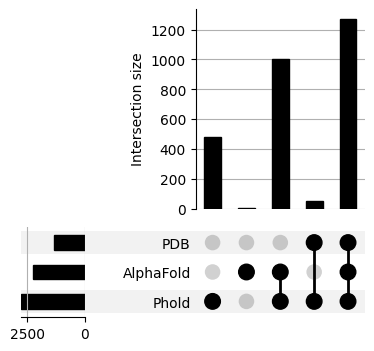

In [30]:
# let's have a look at the complementarity of the annotations through an unpset plot
set_names = ["AlphaFold", "Phold", "PDB"]
all_elems = set(list(afdb_ann_phar_match_bah_ann["protein"])).union(set(list(phold_ann_phar_match_bah_ann["protein"]))).union(set(list(pdb_ann_phar_match_bah_ann["protein"])))
df = pd.DataFrame([[e in set(list(afdb_ann_phar_match_bah_ann["protein"])), e in set(list(phold_ann_phar_match_bah_ann["protein"])), e in set(list(pdb_ann_phar_match_bah_ann["protein"]))] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "upset_bah_pharokka_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [31]:
# the final annotation rate of truly unannotated proteins, when combining all databases
per_ann_phar_joint = "{:.2f}".format(len(all_elems)*100/num_tba_p)
print(f"Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates {per_ann_phar_joint}% of all Pharokka annotated clusters.")

Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates 98.98% of all Pharokka annotated clusters.


##### Subset of truly unannotated clusters

Let's have a look per database (PDB, AFdb) and method (Phold, BH, BAH) at the annotation rates, for proteins that could not be annotated by Pharokka (should be the 'hard set').

In [32]:
num_tba_ta = len(proteins_w_structure) - len(ncbi_id_ann) # the total number of protein clusters that was annotated by Pharokka

In [33]:
# PDB database statistics
pdb_ann_ta = pdb_ann[pdb_ann["pharokka_ann"] == False]
pdb_ann_ta_match = pdb_ann_ta[pdb_ann_ta["empty"] == False]
pdb_ann_ta_match_bh_ann = pdb_ann_ta_match[pdb_ann_ta_match["annotation_found_bh"] == True]
pdb_ann_ta_match_bh_unann = pdb_ann_ta_match[pdb_ann_ta_match["annotation_found_bh"] == False]
pdb_ann_ta_match_bah_ann = pdb_ann_ta_match[pdb_ann_ta_match["annotation_found_bah"] == True]
pdb_ann_ta_match_bah_unann = pdb_ann_ta_match[pdb_ann_ta_match["annotation_found_bah"] == False]
    # number of truly unannotated clusters with no match against PDB
num_pdb_ann_ta_nomatch = len(pdb_ann_ta[pdb_ann_ta["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against PDB
per_pdb_ann_ta_nomatch = "{:.2f}".format(num_pdb_ann_ta_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BH method)
num_pdb_ann_ta_match_bh_ann = len(pdb_ann_ta_match_bh_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BH
per_pdb_ann_ta_bh_ann = "{:.2f}".format(num_pdb_ann_ta_match_bh_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BH
per_pdb_ann_ta_match_bh_ann = "{:.2f}".format(num_pdb_ann_ta_match_bh_ann*100/(num_tba_ta-num_pdb_ann_ta_nomatch)) 
    # number of truly unannotated clusters with annotated match (BH method)
num_pdb_ann_ta_match_bh_unann = len(pdb_ann_ta_match_bh_unann) 
    # number of truly unannotated clusters with annotated match (BAH method)
num_pdb_ann_ta_match_bah_ann = len(pdb_ann_ta_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_pdb_ann_ta_bah_ann = "{:.2f}".format(num_pdb_ann_ta_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_pdb_ann_ta_match_bah_ann = "{:.2f}".format(num_pdb_ann_ta_match_bah_ann*100/(num_tba_ta-num_pdb_ann_ta_nomatch)) 
    # number of truly unannotated clusters with unannotated match (BAH method)
num_pdb_ann_ta_match_bah_unann = len(pdb_ann_ta_match_bah_unann)  
print(f"Statistics of annotation using the PDB database:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_ta-num_pdb_ann_ta_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_ta_nomatch}")
print(f"------------------------------------------------")
print(f"Best hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_ta_match_bh_ann} ({per_pdb_ann_ta_match_bh_ann}% of all those with matches, {per_pdb_ann_ta_bh_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_ta_match_bh_unann + num_pdb_ann_ta_nomatch} ({num_pdb_ann_ta_nomatch} due to no matches)")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_ta_match_bah_ann} ({per_pdb_ann_ta_match_bah_ann}% of all those with matches, {per_pdb_ann_ta_bah_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_ta_match_bah_unann + num_pdb_ann_ta_nomatch} ({num_pdb_ann_ta_nomatch} due to no matches)")

Statistics of annotation using the PDB database:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 508
    Number of clusters without matches: 7138
------------------------------------------------
Best hit annotation method:
    Number of clusters with annotations: 497 (97.83% of all those with matches, 6.50% of all truly unannotated clusters)
    Number of clusters without annotations: 7149 (7138 due to no matches)
Best annotated hit annotation method:
    Number of clusters with annotations: 502 (98.82% of all those with matches, 6.57% of all truly unannotated clusters)
    Number of clusters without annotations: 7144 (7138 due to no matches)


In [34]:
# AlphaFold database statistics
afdb_ann_ta = afdb_ann[afdb_ann["pharokka_ann"] == False]
afdb_ann_ta_match = afdb_ann_ta[afdb_ann_ta["empty"] == False]
afdb_ann_ta_match_bh_ann = afdb_ann_ta_match[afdb_ann_ta_match["annotation_found_bh"] == True]
afdb_ann_ta_match_bh_unann = afdb_ann_ta_match[afdb_ann_ta_match["annotation_found_bh"] == False]
afdb_ann_ta_match_bah_ann = afdb_ann_ta_match[afdb_ann_ta_match["annotation_found_bah"] == True]
afdb_ann_ta_match_bah_unann = afdb_ann_ta_match[afdb_ann_ta_match["annotation_found_bah"] == False]
    # number of truly unannotated clusters with no match against AlphaFold database
num_afdb_ann_ta_nomatch = len(afdb_ann_ta[afdb_ann_ta["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against AlphaFold database
per_afdb_ann_ta_nomatch = "{:.2f}".format(num_afdb_ann_ta_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BH method)
num_afdb_ann_ta_match_bh_ann = len(afdb_ann_ta_match_bh_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BH
per_afdb_ann_ta_bh_ann = "{:.2f}".format(num_afdb_ann_ta_match_bh_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BH
per_afdb_ann_ta_match_bh_ann = "{:.2f}".format(num_afdb_ann_ta_match_bh_ann*100/(num_tba_ta-num_afdb_ann_ta_nomatch)) 
    # number of truly unannotated clusters with annotated match (BH method)
num_afdb_ann_ta_match_bh_unann = len(afdb_ann_ta_match_bh_unann) 
    # number of truly unannotated clusters with annotated match (BAH method)
num_afdb_ann_ta_match_bah_ann = len(afdb_ann_ta_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_afdb_ann_ta_bah_ann = "{:.2f}".format(num_afdb_ann_ta_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_ta_match_bah_ann = "{:.2f}".format(num_afdb_ann_ta_match_bah_ann*100/(num_tba_ta-num_afdb_ann_ta_nomatch)) 
    # number of truly unannotated clusters with unannotated match (BAH method)
num_afdb_ann_ta_match_bah_unann = len(afdb_ann_ta_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_nomatch}")
print(f"------------------------------------------------")
print(f"Best hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_match_bh_ann} ({per_afdb_ann_ta_match_bh_ann}% of all those with matches, {per_afdb_ann_ta_bh_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_match_bh_unann + num_afdb_ann_ta_nomatch} ({num_afdb_ann_ta_nomatch} due to no matches)")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_match_bah_ann} ({per_afdb_ann_ta_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_bah_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_match_bah_unann + num_afdb_ann_ta_nomatch} ({num_afdb_ann_ta_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best hit annotation method:
    Number of clusters with annotations: 441 (12.75% of all those with matches, 5.77% of all truly unannotated clusters)
    Number of clusters without annotations: 7205 (4188 due to no matches)
Best annotated hit annotation method:
    Number of clusters with annotations: 1492 (43.15% of all those with matches, 19.51% of all truly unannotated clusters)
    Number of clusters without annotations: 6154 (4188 due to no matches)


In [35]:
# Phold statistics
phold_ann_ta = phold_structure_df[phold_structure_df["pharokka_ann"] == False]
phold_ann_ta_match = phold_ann_ta[phold_ann_ta["annotation_source"] == "foldseek"]
phold_ann_ta_match_bah_ann = phold_ann_ta_match[phold_ann_ta_match["function"] != "unknown function"]
phold_ann_ta_match_bah_unann = phold_ann_ta_match[phold_ann_ta_match["function"] == "unknown function"]
    # number of truly unannotated clusters with no match against Phold databases
num_phold_ann_ta_nomatch = len(phold_ann_ta[phold_ann_ta["annotation_source"] != "foldseek"]) 
    # percentage of truly unannotated clusters with no match against Phold databases
per_phold_ann_ta_nomatch = "{:.2f}".format(num_phold_ann_ta_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_phold_ann_ta_match_bah_ann = len(phold_ann_ta_match_bah_ann) 
    # of the truly unannotated clusters, which percentage gets annotated using BAH
per_phold_ann_ta_bah_ann = "{:.2f}".format(num_phold_ann_ta_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_phold_ann_ta_match_bah_ann = "{:.2f}".format(num_phold_ann_ta_match_bah_ann*100/(num_tba_ta-num_phold_ann_ta_nomatch)) 
    # number of truly unannotated clusters with unannotated match (BAH method)
num_phold_ann_ta_match_bah_unann = len(phold_ann_ta_match_bah_unann)  
print(f"Statistics of annotation using Phold:")
print(f"------------------------------------------------")
print(f"Matches against the Phold databases:")
print(f"    Number of clusters with matches: {num_tba_ta-num_phold_ann_ta_nomatch}")
print(f"    Number of clusters without matches: {num_phold_ann_ta_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_phold_ann_ta_match_bah_ann} ({per_phold_ann_ta_match_bah_ann}% of all those with matches, {per_phold_ann_ta_bah_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_phold_ann_ta_match_bah_unann+num_phold_ann_ta_nomatch} ({num_phold_ann_ta_nomatch} due to no matches)")

Statistics of annotation using Phold:
------------------------------------------------
Matches against the Phold databases:
    Number of clusters with matches: 5030
    Number of clusters without matches: 2616
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 1726 (34.31% of all those with matches, 22.57% of all truly unannotated clusters)
    Number of clusters without annotations: 5920 (2616 due to no matches)


C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

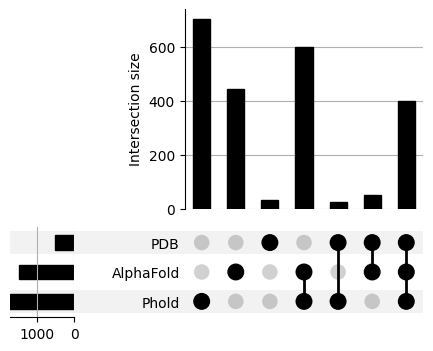

In [36]:
# let's have a look at the complementarity of the annotations through an unpset plot
set_names = ["AlphaFold", "Phold", "PDB"]
all_elems = set(list(afdb_ann_ta_match_bah_ann["protein"])).union(set(list(phold_ann_ta_match_bah_ann["protein"]))).union(set(list(pdb_ann_ta_match_bah_ann["protein"])))
df = pd.DataFrame([[e in set(list(afdb_ann_ta_match_bah_ann["protein"])), e in set(list(phold_ann_ta_match_bah_ann["protein"])), e in set(list(pdb_ann_ta_match_bah_ann["protein"]))] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "upset_bah_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [37]:
# the final annotation rate of truly unannotated proteins, when combining all databases
per_ann_ta_joint = "{:.2f}".format(len(all_elems)*100/num_tba_ta)
print(f"Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates {per_ann_ta_joint}% of all truly unannotated clusters.")

Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates 29.44% of all truly unannotated clusters.


In [38]:
# what percentage of all truly unannotated proteins is this?
agg_df = cluster_protein_match.groupby("cluster_rep").size().reset_index(name = "counts")
sum(agg_df[agg_df["cluster_rep"].isin(all_elems)]["counts"])/sum(agg_df[agg_df["cluster_rep"].isin(list(phold_ann_ta["protein"]))]["counts"])

0.3118631321677007

#### Goal 4 : Implement a best annotated hit annotation method, that uses information fetched from UniProt to annotate proteins

Let's investigate whether switching out database contained protein annotations, for UniProt annotations, helps improve the overall annotation rate.

##### Step 1 - fetching UniProt annotations

First, we have to accumulate all the UniProt identifiers we wish to query. For the AlphaFold database results, this information can simply be fetched from the FoldSeek output.

In [39]:
# function to extract UniProt ID from the FoldSeek target column
def get_UniProtID_from_target(target):
    uniprot_id = target.split('-')[1]
    return uniprot_id

In [40]:
# instantiate empty dictionary
dict_af50m_UniProtID_NCBIid = {}

In [41]:
# loop through batches, then through proteins
for index_batch, batch in dict_batch_comp.items():
    batch_dir = os.path.join(comp_out_dir, f"batch_{index_batch}", f"batch_{index_batch}")
    for protein in batch:
        # read the filtered data
        filtered_foldseek = pd.read_csv(os.path.join(batch_dir, f"{protein}_foldseek_af50m_filtered.csv"))
        # check if it has any content
        if not filtered_foldseek.empty:
            # loop over entries
            for i in range(0,len(filtered_foldseek)):
                # extract UniProt ID
                uniprot_id = get_UniProtID_from_target(filtered_foldseek.at[i, "target"])
                # if UniProt ID already in dictionary: add NCBI ID to list of already matched NCBI IDs as value for the UniProt ID
                if uniprot_id in dict_af50m_UniProtID_NCBIid.keys():
                    prot_list = dict_af50m_UniProtID_NCBIid.get(uniprot_id)
                # if UniProt ID not yet in dictionary: create new key-value pair linking NCBI ID to UniProt ID
                if uniprot_id not in dict_af50m_UniProtID_NCBIid.keys():
                    prot_list = list()
                prot_list.append(protein)
                dict_af50m_UniProtID_NCBIid[uniprot_id] = list(set(prot_list))

For the PDB, we first have to cross link PDB ID and chain combinations to UniProt IDs. We will exclude any obsolete PDB IDs. 

*This was executed in July, 2024, and not repeated here*

In [ ]:
# list of obsolete PDB IDs on date of search (July 15th, 2024)
obsolete_ids = Bio.PDB.PDBList.get_all_obsolete(Bio.PDB.PDBList())

In [42]:
# read from file
with open(os.path.join(master_dir, "associated_data", "list_obsolete_PDB_ids_15jul2024.txt"), "r") as file:
    obsolete_ids = [line.strip() for line in file]

In [43]:
# necessary functions to ...

# from FoldSeek target column, extract PDB id and chain
def get_PDBid_chain_from_target(target):
    pdb_id = target.split('.')[0]
    chain = target.split('_')[-1]
    return pdb_id, chain

# check if PDB ID is obsolete
def check_PDBid_active(pdb_id, obsolete_list):
    if pdb_id.upper() in obsolete_list:
        return False
    else:
        return True

# from PDB ID, get all PDB polymer entities
def get_PDB_entities_from_entry(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    r = sess.get(url)
    data = json.loads(r.text)
    return data["rcsb_entry_container_identifiers"].get("polymer_entity_ids")

# match PDB entity to protein chain
def get_PDB_entity_with_chain(entity_ids,pdb_id,chain):
    for entity in entity_ids:
        url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity}"
        r = sess.get(url)
        data = json.loads(r.text)
        # assumption: FoldSeek gives author chain naming, not PDB renamed chain names
        if chain in data["rcsb_polymer_entity_container_identifiers"].get("auth_asym_ids"):
            return entity
        else:
            continue

# get UniProt ID based on the PDB ID and entity (corresponding to the chain reported by FoldSeek)
def get_UniProt_from_PDB_entity(pdb_id,entity):
    url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity}"
    r = sess.get(url)
    if not r.ok:
      r.raise_for_status()
    data = json.loads(r.text)
    return data["rcsb_polymer_entity_container_identifiers"].get("uniprot_ids")

In [44]:
# instantiate empty dictionaries
dict_pdb_UniProtID_NCBIid = {}
dict_pdb_PDBidch_UniProtID = {}

*This was executed in July, 2024, and not repeated here*

In [ ]:
# loop through batches, then through proteins
for index_batch, batch in  dict_batch_comp.items():
    batch_dir = os.path.join(comp_out_dir, f"batch_{index_batch}", f"batch_{index_batch}")
    for protein in batch:
        # read the filtered data
        filtered_foldseek = pd.read_csv(os.path.join(batch_dir, f"{protein}_foldseek_pdb_filtered.csv"))
        # check if it has any content
        if not filtered_foldseek.empty:
            # loop over entries
            for i in range(0,len(filtered_foldseek)):
                # extract PDB ID and chain
                pdb_id, chain = get_PDBid_chain_from_target(filtered_foldseek.at[i,"target"])
                # if PDB ID chain combo already in dictionary
                if f"{pdb_id}_{chain}" in dict_pdb_PDBidch_UniProtID.keys():
                    # get UniProt ID previously stored
                    uniprot_ids = dict_pdb_PDBidch_UniProtID.get(f"{pdb_id}_{chain}")
                    if uniprot_ids is not None:
                        for uniprot_id in uniprot_ids:
                            # add NCBI ID to list of matched UniProt IDs
                            if uniprot_id not in dict_pdb_UniProtID_NCBIid.keys():
                                prot_list = list()
                            if uniprot_id in dict_pdb_UniProtID_NCBIid.keys():
                                prot_list = dict_pdb_UniProtID_NCBIid.get(uniprot_id)
                            prot_list.append(protein)
                            dict_pdb_UniProtID_NCBIid[uniprot_id] = list(set(prot_list))
                    
                # if PDB ID chain combo not yet in dictionary
                if f"{pdb_id}_{chain}" not in dict_pdb_PDBidch_UniProtID.keys():
                    # check if PDB ID is obsolete
                    if not check_PDBid_active(pdb_id, obsolete_ids):
                        # if obsolete, instead of storing a UniProt ID we store "Obsolete PDB ID"
                        dict_pdb_PDBidch_UniProtID[f"{pdb_id}_{chain}"] = "Obsolete PDB ID"
                    if check_PDBid_active(pdb_id, obsolete_ids):
                        # fetch UniProt ID(s) - this can be multiple
                        uniprot_ids = get_UniProt_from_PDB_entity(pdb_id,get_PDB_entity_with_chain(get_PDB_entities_from_entry(pdb_id),pdb_id,chain))
                        # add link PDB id chain combo to UniProt IDs
                        dict_pdb_PDBidch_UniProtID[f"{pdb_id}_{chain}"] = uniprot_ids
                        if uniprot_ids is not None:
                        # link UniProt IDs to NCBI protein ids
                            for uniprot_id in uniprot_ids:
                                if uniprot_id not in dict_pdb_UniProtID_NCBIid.keys():
                                    prot_list = list()
                                if uniprot_id in dict_pdb_UniProtID_NCBIid.keys():
                                    prot_list = dict_pdb_UniProtID_NCBIid.get(uniprot_id)
                                prot_list.append(protein)
                                dict_pdb_UniProtID_NCBIid[uniprot_id] = list(set(prot_list))

In [45]:
# reading in the map between PDB ID + chain and UniProt ID
    # reading from file
with open(os.path.join(data_dir, "dict_pdb_PDBidch_UniProtID.csv"), newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dict_pdb_PDBidch_UniProtID = row
    # proper parsing of lists in the values
for key, value in dict_pdb_PDBidch_UniProtID.items():
    updated_value = list()
    if "Obsolete PDB ID" in value:
        updated_value.append("Obsolete PDB ID")
    elif value == '':
        updated_value.append(None)
    elif "," not in value:
        updated_value.append(value[2:-2])
    if "," in value:
        cleaned_value = value[1:-1]
        for entry in cleaned_value.split(","):
            updated_value.append(entry.strip()[1:-1])
    dict_pdb_PDBidch_UniProtID[key] = updated_value

In [46]:
# reading in the map between UniProt and NCBI id, for the PDB results
    # reading from file
with open(os.path.join(data_dir, "dict_pdb_UniProtID_NCBIid.csv"), newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dict_pdb_UniProtID_NCBIid = row
    # proper parsing of lists in the values
for key, value in dict_pdb_UniProtID_NCBIid.items():
    updated_value = list()
    if "," in value:
        cleaned_value = value[1:-1]
        for entry in cleaned_value.split(","):
            updated_value.append(int(entry.strip()[1:-1]))
    dict_pdb_UniProtID_NCBIid[key] = updated_value

Then, we will extract the function description for all proteins for which we obtained the UniProt IDs from the filtered FoldSeek results. 

In [47]:
# functions to ...

# get protein name, for a single UniProt ID
def get_protein_name_string(uniprot_id):
    # note: unsure if protein_name is a required field, if we get errors, look into this!
    url = f"https://rest.uniprot.org/uniprotkb/search?query={uniprot_id}&fields=protein_name&format=tsv"
    r = sess.get(url)
    r.raise_for_status()
    content = r.text
    names = content.split('\n')[1:-1]
    # if the UniProt entry was marked as obsolete, access its UniParc accession
    if "deleted" in names:
        try:
            return ";".join([str(name) for name in get_uniparc_entry(uniprot_id)])
        except TypeError:
            return "WARNING UniProt ID is obsolete and issue with fetching UniParc information"
    else:
        return ";".join([str(name) for name in names])

# get protein names (and whether the protein is still in UniProt) from a UniParc entry matching the obsolete UniProt ID
def get_uniparc_entry(uniprot_id):
    requestURL = f"https://www.ebi.ac.uk/proteins/api/uniparc/accession/{uniprot_id}"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
    responseBody = r.text
    data = json.loads(r.text)
    uniparc_entries = []
    uniparc_entries.append("WARNING UniProt ID obsolete, info fetched from UniParc")
    for i in range(0,len(data["dbReference"])):
        for j in data["dbReference"][i].get("property"):
            if j.get("type") == "protein_name":
                uniparc_entries.append(f"{data['dbReference'][i].get('id')} : {j.get('value')} (active UniProt ID: {data['dbReference'][i].get('active')})")
    return uniparc_entries

In [48]:
 # list of failed IDs
failed_UniProtID_function = list()
# dict storing functions
dict_UniProtID_function = {}
# get all the UniProt IDs from the two dictionaries:
uniprot_to_search = list(set(list(dict_af50m_UniProtID_NCBIid.keys()) + list(dict_pdb_UniProtID_NCBIid.keys())))

*This was executed July 15-16, 2024, on UniProt release 2024_03, and not repeated here.*

In [ ]:
# search each element, store in dict
for uniprot_id in uniprot_to_search:
    # this loop allows us to rerun upon errors
    if uniprot_id in dict_UniProtID_function.keys():
        continue
    if uniprot_id not in dict_UniProtID_function.keys():
        try:
            function = get_protein_name_string(uniprot_id)
            dict_UniProtID_function[uniprot_id] = function
        except requests.exceptions.ReadTimeout:
            failed_UniProtID_function.append(uniprot_id)
            print(f"Failed to fetch information on UniProt ID {uniprot_id} due to ReadTimeout error. Stored this ID to the list of failed IDs. Try again later.")
        except JSONDecodeError:
            failed_UniProtID_function.append(uniprot_id)
            print(f"Failed to fetch information on UniProt ID {uniprot_id} due to JSON decode error. Stored this ID to the list of failed IDs. Try again later.")
        except requests.exceptions.ConnectionError:
            failed_UniProtID_function.append(uniprot_id)
            print(f"Failed to fetch information on UniProt ID {uniprot_id} due to Connection error. Stored this ID to the list of failed IDs. Try again later.")

In [49]:
# reading in the map between UniProt ID and UniProt protein names
    # since I did not use DictWriter properly, we have created too large fields for DictReader to reader, which I first have to accomodate here
max_int = sys.maxsize
while True:
    # decrease the max_int value by factor 10 
    # as long as the OverflowError occurs.
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = int(max_int/10)
csv.field_size_limit(max_int)
    # actually reading in the data
with open(os.path.join(data_dir, "dict_UniProtID_function.csv"), newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dict_UniProtID_function = row

##### Step 2 - annotation using UniProt fetched annotations

Now that we have fetched these annotations from UniProt, we can use them to annotate the proteins in our dataset. To do this, we have to write some new functions, and refine some existing ones.

In [50]:
# functions to ...

# obtain the function linked to a specific UniProt ID
def get_function_from_UniProtID(uniprot_id):
    if uniprot_id in dict_UniProtID_function.keys():
        descr = dict_UniProtID_function.get(uniprot_id)
    if uniprot_id not in dict_UniProtID_function.keys():
        descr = "[UNIPROT RECORD NOT YET FETCHED]"
    return descr

# obtain the function linked to a specific PDB ID chain 
def get_function_from_PDB(pdb_id, chain):
    if f"{pdb_id}_{chain}" in dict_pdb_PDBidch_UniProtID.keys():
        uniprot_ids = dict_pdb_PDBidch_UniProtID.get(f"{pdb_id}_{chain}")
        if "Obsolete PDB ID" in uniprot_ids:
            descr = "WARNING This PDB ID is obsolete, hence, no information could be fetched"
        if None in uniprot_ids:
            descr = "WARNING No UniProt ID was linked to this PDB entry, hence, no information could be fetched"
        else:
            string = ""
            for uniprot_id in uniprot_ids:
                string += get_function_from_UniProtID(uniprot_id) + f" [UniProt ID: {uniprot_id}] "
            descr = string
    if f"{pdb_id}_{chain}" not in dict_pdb_PDBidch_UniProtID.keys():
        descr = "[PDB RECORD NOT YET FETCHED]"
    return descr

In [51]:
# functions for dealing with UniProt fetching issues

# first things first, a function to recognize whether we had to resort to UniParc information
def uniparc_needed(descr):
    if re.search("UniParc", descr) != None:
        return True
    else:
        return False

# a function to recognize whether the UniParc fetch failed
def uniparc_fail(descr):
    if re.fullmatch("WARNING UniProt ID is obsolete and issue with fetching UniParc information", descr) != None:
        return True
    else:
        return False

# a function that splits the different results obtained from UniParc into a list of annotations, 
    # for which we can then check whether this list contains a proper annotation
def uniparc2list(descr):
    # get the different uniparc entries
    uniparc_entries = descr.split(';')[1:]
    entries_clean = list()
    for entry in uniparc_entries:
        # get the protein description out of the entry 
        entry_cleaned_step1 = re.sub(r"[\w+]+ : ", "", entry)
        entry_cleaned_step2 = re.sub(r" \(active UniProt ID: [YN]\)", "", entry_cleaned_step1)
        entries_clean.append(entry_cleaned_step2)
    return entries_clean

# a function that extracts the best annotation from the list of annotations obtained from UniParc
def extract_best_uniparc(entries_list):
    annotation_found = False
    for descr in entries_list:
        if is_hypothetical_af(descr) == False:
            annotation_found = True
            best_ann = descr
            break
    if annotation_found == False:
        best_ann = entries_list[0]
    return best_ann

In [52]:
def find_best_annotation_foldseek_af50m_up(dataframe):
    annotation_found = False
    for i in range(0, len(dataframe)):
        uniprot_id = get_UniProtID_from_target(dataframe.at[i, "target"])
        descr = get_function_from_UniProtID(uniprot_id)
        # checking if UniProt entry has been fetched
        if descr == "[UNIPROT RECORD NOT YET FETCHED]":
            continue
        # checking if entry contains information from UniParc:
        uniparc_used = False
        if uniparc_needed(descr):
            uniparc_used = True
            if uniparc_fail(descr) == False:
                descr = extract_best_uniparc(uniparc2list(descr))
            if uniparc_fail(descr) == True:
                continue
        # checking whether (best UniParc) description is annotated
        if is_hypothetical_af(descr) == False:
            annotation_found = True
            best_ann_index = i
            break
    # if all annotations are hypothetical the annotation_found flag remains False
    if annotation_found == False:
        best_ann_index = 0
    best_ann = get_function_from_UniProtID(get_UniProtID_from_target(dataframe.at[best_ann_index, "target"]))
    return best_ann, annotation_found

In [53]:
# functions for dealing with PDB specific issues

# a function for splitting multiple pdb descriptions into a list
def pdbdescr2list(pdb_descr):
    str_to_split = re.sub(r" \[UniProt ID: [\w+]+\]", "SPLITHERE", pdb_descr)
    descr_list = str_to_split.split("SPLITHERE")[:-1]
    stripped_list = [descr.strip() for descr in descr_list]
    return stripped_list

# a function that extracts the best annotation from the list of annotations obtained from PDB
def extract_best_pdb(entries_list):
    annotation_found = False
    for descr in entries_list:
        if is_hypothetical_af(descr) == False:
            annotation_found = True
            best_ann = descr
            break
    if annotation_found == False:
        best_ann = entries_list[0]
    return best_ann

In [54]:
# actual method for parsing
def find_best_annotation_foldseek_pdb_up(dataframe):
    annotation_found = False
    for i in range(0, len(dataframe)):
        pdb_id, chain = get_PDBid_chain_from_target(dataframe.at[i,"target"])
        full_descr = get_function_from_PDB(pdb_id, chain)
        if re.fullmatch(r"\[(PDB|UNIPROT) RECORD NOT YET FETCHED\]", full_descr) != None:
            continue
        if full_descr == "WARNING This PDB ID is obsolete, hence, no information could be fetched":
            continue
        if full_descr == "WARNING No UniProt ID was linked to this PDB entry, hence, no information could be fetched":
            continue
        descr = extract_best_pdb(pdbdescr2list(full_descr))
        # checking if entry contains information from UniParc:
        uniparc_used = False
        if uniparc_needed(descr):
            uniparc_used = True
            if uniparc_fail(descr) == False:
                descr = extract_best_uniparc(uniparc2list(descr))
            if uniparc_fail(descr) == True:
                continue
        # how will we deal with uniparc lists though
        # get top annotation that is not a hypothetical
        if is_hypothetical_af(descr) == False:
            annotation_found = True
            best_ann_index = i
            break
    # if all annotations are hypothetical the annotation_found flag remains False
    if annotation_found == False:
        best_ann_index = 0
    pdb_id, chain = get_PDBid_chain_from_target(dataframe.at[best_ann_index,"target"])
    best_ann = get_function_from_PDB(pdb_id, chain)
    return best_ann, annotation_found

In [ ]:
# writing results to file for inspection
file = open(os.path.join(one_hit_dir, "best_annotated_hit_uniprot_annotations.tsv"), "w")
file.write(f"protein\tpdb/af50m\tempty\tbest_ann\tannotation_found\n")
for batch, protein_set in dict_batch_comp.items():
    for protein in protein_set:
        pdb_fil, af50m_fil = read_foldseek_protein(batch, protein)
        if pdb_fil.empty:
            file.write(f"{protein}\tpdb\tTrue\tNA\tNA\n")
        if not pdb_fil.empty:
            pdb_fil = pdb_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_best_annotation_foldseek_pdb_up(pdb_fil)
            file.write(f"{protein}\tpdb\tFalse\t{best_ann}\t{annotation_found}\n")
        if af50m_fil.empty:
            file.write(f"{protein}\taf50m\tTrue\tNA\tNA\n")
        if not af50m_fil.empty:
            af50m_fil = af50m_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found = find_best_annotation_foldseek_af50m_up(af50m_fil)
            file.write(f"{protein}\taf50m\tFalse\t{best_ann}\t{annotation_found}\n") 
file.close()

#### Goal 5 : Assess a best annotated hit annotation method, that uses information fetched from UniProt to annotate proteins

Let's now assess whether this method did improve annotation:

In [55]:
best_ann_hit_up_df = pd.read_csv(os.path.join(one_hit_dir, "best_annotated_hit_uniprot_annotations.tsv"), sep = "\t")

In [56]:
pdb_ann_up = best_ann_hit_up_df[best_ann_hit_up_df["pdb/af50m"] == "pdb"]
afdb_ann_up = best_ann_hit_up_df[best_ann_hit_up_df["pdb/af50m"] == "af50m"]

In [57]:
# adding a column to store information on Pharokka annotation
pdb_ann_up["pharokka_ann"] = False
pdb_ann_up.loc[pdb_ann_up["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True
afdb_ann_up["pharokka_ann"] = False
afdb_ann_up.loc[afdb_ann_up["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True

C:\Users\hanne\AppData\Local\Temp\ipykernel_13196\3051604374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdb_ann_up["pharokka_ann"] = False
C:\Users\hanne\AppData\Local\Temp\ipykernel_13196\3051604374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afdb_ann_up["pharokka_ann"] = False


##### Subset of clusters annotated by Pharokka

Let's have a look per database (PDB, AFdb) at the annotation rates, for proteins annotated by Pharokka (should be the 'easy set').

In [58]:
# PDB database statistics
pdb_ann_phar_up = pdb_ann_up[pdb_ann_up["pharokka_ann"] == True]
pdb_ann_phar_up_match = pdb_ann_phar_up[pdb_ann_phar_up["empty"] == False]
pdb_ann_phar_up_match_bah_ann = pdb_ann_phar_up_match[pdb_ann_phar_up_match["annotation_found"] == True]
pdb_ann_phar_up_match_bah_unann = pdb_ann_phar_up_match[pdb_ann_phar_up_match["annotation_found"] == False]
    # number of Pharokka annotated clusters with no match against PDB
num_pdb_ann_phar_up_nomatch = len(pdb_ann_phar_up[pdb_ann_phar_up["empty"] == True]) 
    # percentage of Pharokka annotated clusters with no match against PDB
per_pdb_ann_phar_up_nomatch = "{:.2f}".format(num_pdb_ann_phar_up_nomatch*100/num_tba_p)
    # number of Pharokka annotated clusters with annotated match (BAH method)
num_pdb_ann_phar_up_match_bah_ann = len(pdb_ann_phar_up_match_bah_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BAH
per_pdb_ann_phar_up_bah_ann = "{:.2f}".format(num_pdb_ann_phar_up_match_bah_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BAH
per_pdb_ann_phar_up_match_bah_ann = "{:.2f}".format(num_pdb_ann_phar_up_match_bah_ann*100/(num_tba_p-num_pdb_ann_phar_up_nomatch)) 
    # number of Pharokka annotated clusters with unannotated match (BAH method)
num_pdb_ann_phar_up_match_bah_unann = len(pdb_ann_phar_up_match_bah_unann)  
print(f"Statistics of annotation using the PDB database:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_p-num_pdb_ann_phar_up_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_phar_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_phar_up_match_bah_ann} ({per_pdb_ann_phar_up_match_bah_ann}% of all those with matches, {per_pdb_ann_phar_up_bah_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_phar_up_match_bah_unann + num_pdb_ann_phar_up_nomatch} ({num_pdb_ann_phar_up_nomatch} due to no matches)")

Statistics of annotation using the PDB database:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 1337
    Number of clusters without matches: 1498
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 1286 (96.19% of all those with matches, 45.36% of all Pharokka annotated clusters)
    Number of clusters without annotations: 1549 (1498 due to no matches)


In [59]:
# AlphaFold database statistics
afdb_ann_phar_up = afdb_ann_up[afdb_ann_up["pharokka_ann"] == True]
afdb_ann_phar_up_match = afdb_ann_phar_up[afdb_ann_phar_up["empty"] == False]
afdb_ann_phar_up_match_bah_ann = afdb_ann_phar_up_match[afdb_ann_phar_up_match["annotation_found"] == True]
afdb_ann_phar_up_match_bah_unann = afdb_ann_phar_up_match[afdb_ann_phar_up_match["annotation_found"] == False]
    # number of Pharokka annotated clusters with no match against AlphaFold database
num_afdb_ann_phar_up_nomatch = len(afdb_ann_phar_up[afdb_ann_phar_up["empty"] == True]) 
    # percentage of Pharokka annotated clusters with no match against AlphaFold database
per_afdb_ann_phar_up_nomatch = "{:.2f}".format(num_afdb_ann_phar_up_nomatch*100/num_tba_p)
    # number of Pharokka annotated clusters with annotated match (BAH method)
num_afdb_ann_phar_up_match_bah_ann = len(afdb_ann_phar_up_match_bah_ann) 
    # of the Pharokka annotated clusters which percentage gets annotated using BAH
per_afdb_ann_phar_up_bah_ann = "{:.2f}".format(num_afdb_ann_phar_up_match_bah_ann*100/(num_tba_p)) 
    # of the Pharokka annotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_phar_up_match_bah_ann = "{:.2f}".format(num_afdb_ann_phar_up_match_bah_ann*100/(num_tba_p-num_afdb_ann_phar_up_nomatch)) 
    # number of Pharokka annotated clusters with unannotated match (BAH method)
num_afdb_ann_phar_up_match_bah_unann = len(afdb_ann_phar_up_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_p-num_afdb_ann_phar_up_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_phar_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_phar_up_match_bah_ann} ({per_afdb_ann_phar_up_match_bah_ann}% of all those with matches, {per_afdb_ann_phar_up_bah_ann}% of all Pharokka annotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_phar_up_match_bah_unann + num_afdb_ann_phar_up_nomatch} ({num_afdb_ann_phar_up_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 2577
    Number of clusters without matches: 258
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 2514 (97.56% of all those with matches, 88.68% of all Pharokka annotated clusters)
    Number of clusters without annotations: 321 (258 due to no matches)


C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

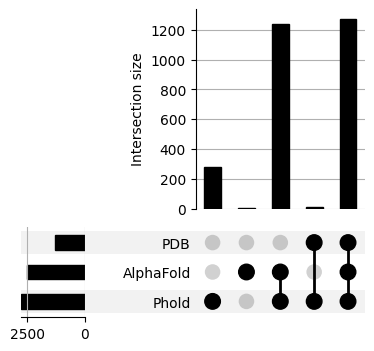

In [60]:
# let's have a look at the complementarity of the annotations through an unpset plot
set_names = ["AlphaFold", "Phold", "PDB"]
all_elems = set(list(afdb_ann_phar_up_match_bah_ann["protein"])).union(set(list(phold_ann_phar_match_bah_ann["protein"]))).union(set(list(pdb_ann_phar_up_match_bah_ann["protein"])))
df = pd.DataFrame([[e in set(list(afdb_ann_phar_up_match_bah_ann["protein"])), e in set(list(phold_ann_phar_match_bah_ann["protein"])), e in set(list(pdb_ann_phar_up_match_bah_ann["protein"]))] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "upset_bah_up_pharokka_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [61]:
# the final annotation rate of pharokka annotated proteins, when combining all databases
per_ann_phar_up_joint = "{:.2f}".format(len(all_elems)*100/num_tba_p)
print(f"Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates {per_ann_phar_up_joint}% of all Pharokka annotated clusters.")

Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates 99.01% of all Pharokka annotated clusters.


##### Subset of truly unannotated clusters

Let's have a look per database (PDB, AFdb) for proteins that could not be annotated by Pharokka (should be the 'hard set').

In [62]:
# PDB database statistics
pdb_ann_ta_up = pdb_ann_up[pdb_ann_up["pharokka_ann"] == False]
pdb_ann_ta_up_match = pdb_ann_ta_up[pdb_ann_ta_up["empty"] == False]
pdb_ann_ta_up_match_bah_ann = pdb_ann_ta_up_match[pdb_ann_ta_up_match["annotation_found"] == True]
pdb_ann_ta_up_match_bah_unann = pdb_ann_ta_up_match[pdb_ann_ta_up_match["annotation_found"] == False]
    # number of truly unannotated clusters with no match against PDB
num_pdb_ann_ta_up_nomatch = len(pdb_ann_ta_up[pdb_ann_ta_up["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against PDB
per_pdb_ann_ta_up_nomatch = "{:.2f}".format(num_pdb_ann_ta_up_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_pdb_ann_ta_up_match_bah_ann = len(pdb_ann_ta_up_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_pdb_ann_ta_up_bah_ann = "{:.2f}".format(num_pdb_ann_ta_up_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_pdb_ann_ta_up_match_bah_ann = "{:.2f}".format(num_pdb_ann_ta_up_match_bah_ann*100/(num_tba_ta-num_pdb_ann_ta_up_nomatch)) 
    # number of truly unannotated clusters with unannotated match (BAH method)
num_pdb_ann_ta_up_match_bah_unann = len(pdb_ann_ta_up_match_bah_unann)  
print(f"Statistics of annotation using the PDB database:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_ta-num_pdb_ann_ta_up_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_ta_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_ta_up_match_bah_ann} ({per_pdb_ann_ta_up_match_bah_ann}% of all those with matches, {per_pdb_ann_ta_up_bah_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_pdb_ann_ta_up_match_bah_unann + num_pdb_ann_ta_up_nomatch} ({num_pdb_ann_ta_up_nomatch} due to no matches)")

Statistics of annotation using the PDB database:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 508
    Number of clusters without matches: 7138
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 482 (94.88% of all those with matches, 6.30% of all truly unannotated clusters)
    Number of clusters without annotations: 7164 (7138 due to no matches)


In [63]:
# AlphaFold database statistics
afdb_ann_ta_up = afdb_ann_up[afdb_ann_up["pharokka_ann"] == False]
afdb_ann_ta_up_match = afdb_ann_ta_up[afdb_ann_ta_up["empty"] == False]
afdb_ann_ta_up_match_bah_ann = afdb_ann_ta_up_match[afdb_ann_ta_up_match["annotation_found"] == True]
afdb_ann_ta_up_match_bah_unann = afdb_ann_ta_up_match[afdb_ann_ta_up_match["annotation_found"] == False]
    # number of truly unannotated clusters with no match against AlphaFold database
num_afdb_ann_ta_up_nomatch = len(afdb_ann_ta_up[afdb_ann_ta_up["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against AlphaFold database
per_afdb_ann_ta_up_nomatch = "{:.2f}".format(num_afdb_ann_ta_up_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_afdb_ann_ta_up_match_bah_ann = len(afdb_ann_ta_up_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_afdb_ann_ta_up_bah_ann = "{:.2f}".format(num_afdb_ann_ta_up_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_ta_up_match_bah_ann = "{:.2f}".format(num_afdb_ann_ta_up_match_bah_ann*100/(num_tba_ta-num_afdb_ann_ta_up_nomatch)) 
    # number of truly unannotated clusters with unannotated match (BAH method)
num_afdb_ann_ta_up_match_bah_unann = len(afdb_ann_ta_up_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_up_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_up_match_bah_ann} ({per_afdb_ann_ta_up_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_up_bah_ann}% of all truly unannotated clusters)")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_up_match_bah_unann + num_afdb_ann_ta_up_nomatch} ({num_afdb_ann_ta_up_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 2656 (76.81% of all those with matches, 34.74% of all truly unannotated clusters)
    Number of clusters without annotations: 4990 (4188 due to no matches)


C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

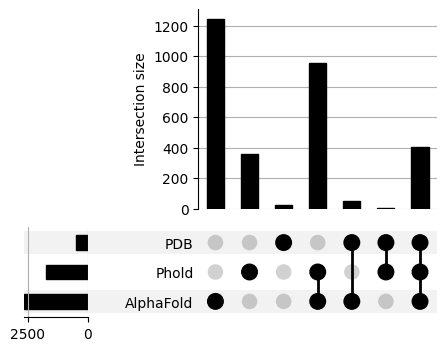

In [64]:
# let's have a look at the complementarity of the annotations through an unpset plot
# set_names = ["AlphaFold", "Phold", "PDB"]
set_names = ["PDB", "AlphaFold", "Phold"]
all_elems = set(list(pdb_ann_ta_up_match_bah_ann["protein"])).union(set(list(afdb_ann_ta_up_match_bah_ann["protein"]))).union(set(list(phold_ann_ta_match_bah_ann["protein"])))
# all_elems = set(list(afdb_ann_ta_up_match_bah_ann["protein"])).union(set(list(phold_ann_ta_match_bah_ann["protein"]))).union(set(list(pdb_ann_ta_up_match_bah_ann["protein"])))
# df = pd.DataFrame([[e in set(list(afdb_ann_ta_up_match_bah_ann["protein"])), e in set(list(phold_ann_ta_match_bah_ann["protein"])), e in set(list(pdb_ann_ta_up_match_bah_ann["protein"]))] for e in all_elems], columns = set_names)
df = pd.DataFrame([[e in set(list(pdb_ann_ta_up_match_bah_ann["protein"])), e in set(list(afdb_ann_ta_up_match_bah_ann["protein"])), e in set(list(phold_ann_ta_match_bah_ann["protein"]))] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation = "horizontal")
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "upset_bah_up_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [65]:
# the final annotation rate of truly unannotated proteins, when combining all databases
per_ann_ta_up_joint = "{:.2f}".format(len(all_elems)*100/num_tba_ta)
print(f"Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates {per_ann_ta_up_joint}% of all truly unannotated clusters.")

Jointly, the best annotated hit method against the PDB, AlphaFold and Phold databases annotates 39.82% of all truly unannotated clusters.


In [66]:
# what percentage of proteins is this (so correcting for cluster size)?
sum(agg_df[agg_df["cluster_rep"].isin(all_elems)]["counts"])/sum(agg_df[agg_df["cluster_rep"].isin(list(afdb_ann_ta_up["protein"]))]["counts"])

0.43410415491633764

##### Figures summarizing annotation rates across methods

Let's first create a bar chart with the results of the different annotation methods when it comes to annotating the proteins that could be annotated with Pharokka.

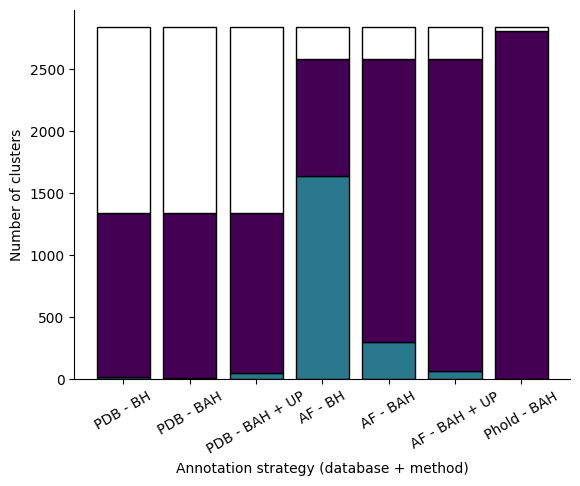

In [67]:
# let's represent this information visually, with a stacked bar chart - Pharokka annotated subset
# creating data dicts
pdb_bh_data = {"no match" : len(pdb_ann_phar[pdb_ann_phar["empty"] == True]) , 
               "annotated match": len(pdb_ann_phar_match_bh_ann), 
               "unannotated match": len(pdb_ann_phar_match_bh_unann)}
afdb_bh_data = {"no match" : len(afdb_ann_phar[afdb_ann_phar["empty"] == True]) , 
               "annotated match": len(afdb_ann_phar_match_bh_ann), 
               "unannotated match": len(afdb_ann_phar_match_bh_unann)}
pdb_bah_data = {"no match" : len(pdb_ann_phar[pdb_ann_phar["empty"] == True]) , 
               "annotated match": len(pdb_ann_phar_match_bah_ann), 
               "unannotated match": len(pdb_ann_phar_match_bah_unann)}
afdb_bah_data = {"no match" : len(afdb_ann_phar[afdb_ann_phar["empty"] == True]) , 
               "annotated match": len(afdb_ann_phar_match_bah_ann), 
               "unannotated match": len(afdb_ann_phar_match_bah_unann)}
pdb_bah_up_data = {"no match" : len(pdb_ann_phar_up[pdb_ann_phar_up["empty"] == True]) , 
               "annotated match": len(pdb_ann_phar_up_match_bah_ann), 
               "unannotated match": len(pdb_ann_phar_up_match_bah_unann)}
afdb_bah_up_data = {"no match" : len(afdb_ann_phar_up[afdb_ann_phar_up["empty"] == True]) , 
               "annotated match": len(afdb_ann_phar_up_match_bah_ann), 
               "unannotated match": len(afdb_ann_phar_up_match_bah_unann)}
phold_data = {"no match" : len(phold_ann_phar[phold_ann_phar["annotation_source"] != "foldseek"]) , 
               "annotated match": len(phold_ann_phar_match_bah_ann), 
               "unannotated match": len(phold_ann_phar_match_bah_unann)}
# put data in long format in a dataframe
data_plot = pd.DataFrame({"Annotation status": list(pdb_bh_data.keys()) + list(pdb_bah_data.keys()) + list(pdb_bah_up_data.keys()) + list(afdb_bh_data.keys()) + list(afdb_bah_data.keys()) + list(afdb_bah_up_data.keys()) + list(phold_data.keys()),
                    "Dataset": ["PDB - BH"] * len(pdb_bh_data.items()) + ["PDB - BAH"] * len(pdb_bah_data.items()) + ["PDB - BAH + UP"] * len(pdb_bah_up_data.items()) + ["AF - BH"] * len(afdb_bh_data.items()) + ["AF - BAH"] * len(afdb_bah_data.items()) + ["AF - BAH + UP"] * len(afdb_bah_up_data.items()) + ["Phold - BAH"] * len(phold_data.items()),
                    "Number of clusters": list(pdb_bh_data.values()) + list(pdb_bah_data.values()) + list(pdb_bah_up_data.values()) + list(afdb_bh_data.values()) + list(afdb_bah_data.values()) + list(afdb_bah_up_data.values()) + list(phold_data.values())})
# one liner to create a stacked bar chart
ax = sns.histplot(data_plot, x = "Dataset", hue = "Annotation status" , weights = "Number of clusters", multiple = "stack", palette = ["#ffffff", "#440154", "#2a788e"], shrink = 0.8, alpha = 1.0, legend = False)
ax.set_ylabel("Number of clusters")
ax.set_xlabel("Annotation strategy (database + method)")
ax.tick_params(axis = "x", labelrotation = 30)
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "annotation_rate_all_methods_pharokka_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

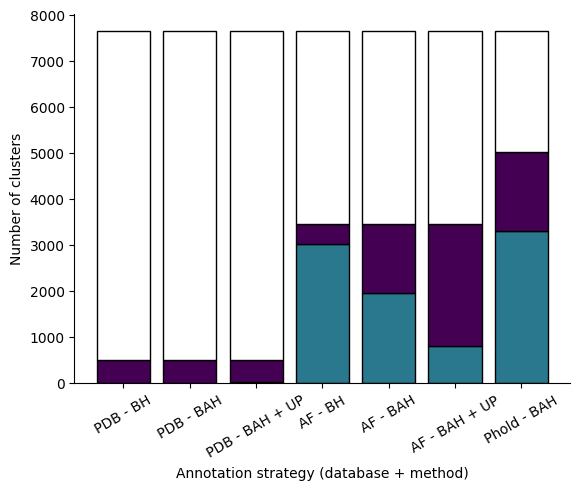

In [68]:
# let's represent this information visually, with a stacked bar chart - truly unannotated subset
# creating data dicts
pdb_bh_data = {"no match" : len(pdb_ann_ta[pdb_ann_ta["empty"] == True]) , 
               "annotated match": len(pdb_ann_ta_match_bh_ann), 
               "unannotated match": len(pdb_ann_ta_match_bh_unann)}
afdb_bh_data = {"no match" : len(afdb_ann_ta[afdb_ann_ta["empty"] == True]) , 
               "annotated match": len(afdb_ann_ta_match_bh_ann), 
               "unannotated match": len(afdb_ann_ta_match_bh_unann)}
pdb_bah_data = {"no match" : len(pdb_ann_ta[pdb_ann_ta["empty"] == True]) , 
               "annotated match": len(pdb_ann_ta_match_bah_ann), 
               "unannotated match": len(pdb_ann_ta_match_bah_unann)}
afdb_bah_data = {"no match" : len(afdb_ann_ta[afdb_ann_ta["empty"] == True]) , 
               "annotated match": len(afdb_ann_ta_match_bah_ann), 
               "unannotated match": len(afdb_ann_ta_match_bah_unann)}
pdb_bah_up_data = {"no match" : len(pdb_ann_ta_up[pdb_ann_ta_up["empty"] == True]) , 
               "annotated match": len(pdb_ann_ta_up_match_bah_ann), 
               "unannotated match": len(pdb_ann_ta_up_match_bah_unann)}
afdb_bah_up_data = {"no match" : len(afdb_ann_ta_up[afdb_ann_ta_up["empty"] == True]) , 
               "annotated match": len(afdb_ann_ta_up_match_bah_ann), 
               "unannotated match": len(afdb_ann_ta_up_match_bah_unann)}
phold_data = {"no match" : len(phold_ann_ta[phold_ann_ta["annotation_source"] != "foldseek"]) , 
               "annotated match": len(phold_ann_ta_match_bah_ann), 
               "unannotated match": len(phold_ann_ta_match_bah_unann)}
# put data in long format in a dataframe
data_plot = pd.DataFrame({"Annotation status": list(pdb_bh_data.keys()) + list(pdb_bah_data.keys()) + list(pdb_bah_up_data.keys()) + list(afdb_bh_data.keys()) + list(afdb_bah_data.keys()) + list(afdb_bah_up_data.keys()) + list(phold_data.keys()),
                    "Dataset": ["PDB - BH"] * len(pdb_bh_data.items()) + ["PDB - BAH"] * len(pdb_bah_data.items()) + ["PDB - BAH + UP"] * len(pdb_bah_up_data.items()) + ["AF - BH"] * len(afdb_bh_data.items()) + ["AF - BAH"] * len(afdb_bah_data.items()) + ["AF - BAH + UP"] * len(afdb_bah_up_data.items()) + ["Phold - BAH"] * len(phold_data.items()),
                    "Number of clusters": list(pdb_bh_data.values()) + list(pdb_bah_data.values()) + list(pdb_bah_up_data.values()) + list(afdb_bh_data.values()) + list(afdb_bah_data.values()) + list(afdb_bah_up_data.values()) + list(phold_data.values())})
# one liner to create a stacked bar chart
ax = sns.histplot(data_plot, x = "Dataset", hue = "Annotation status" , weights = "Number of clusters", multiple = "stack", palette = ["#ffffff", "#440154", "#2a788e"], shrink = 0.8, alpha = 1.0, legend = False)
ax.set_ylabel("Number of clusters")
ax.set_xlabel("Annotation strategy (database + method)")
ax.tick_params(axis = "x", labelrotation = 30)
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig5", "annotation_rate_all_methods_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

#### Goal 6 : Assess whether proteins that get annotated are different from those that do not

In [69]:
# are the proteins annotated special? Come from larger clusters?
agg_df = cluster_protein_match.groupby("cluster_rep").size().reset_index(name = "counts")
agg_df["label"] = "unannotated"
agg_df.loc[agg_df["cluster_rep"].isin(all_elems), "label"] = "annotated"
mannwhitneyu(agg_df[agg_df["label"] == "annotated"]["counts"], agg_df[agg_df["label"] == "unannotated"]["counts"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(11420279.0), pvalue=np.float64(0.26837737100845993))

In [70]:
# let's also have a look at protein size
protein_data = pd.read_table(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "protein_overview.txt"), names=["taxid_name", "ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"])
protein_data = protein_data[protein_data["ncbi_protein_id"].isin(proteins_w_structure)]
protein_data["label"] = "unannotated"
protein_data.loc[protein_data["ncbi_protein_id"].isin(all_elems), "label"] = "annotated"
mannwhitneyu(protein_data[protein_data["label"] == "annotated"]["ncbi_protein_length"], protein_data[protein_data["label"] == "unannotated"]["ncbi_protein_length"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(12310614.5), pvalue=np.float64(9.98748381193111e-13))

In [71]:
# reading in the data - for pLDDT & MSA
pred_qual_df = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", "prediction_metrics.tsv"), sep = "\t")
# adding in the information on structure matches
pred_qual_df["label"] = "unannotated"
pred_qual_df.loc[pred_qual_df["protein"].isin(all_elems), "label"] = "annotated"

In [72]:
# let's test whether proteins matching to structure databases have larger MSAs
mannwhitneyu(pred_qual_df[pred_qual_df["label"]  == "annotated"]["max MSA depth"], pred_qual_df[pred_qual_df["label"]  == "unannotated"]["max MSA depth"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(15470564.0), pvalue=np.float64(7.000611573204745e-192))

In [73]:
# let's test whether proteins matching to structure databases have better pLDDT scores
mannwhitneyu(pred_qual_df[pred_qual_df["label"]  == "annotated"]["avg pLDDT_y"], pred_qual_df[pred_qual_df["label"]  == "unannotated"]["avg pLDDT_y"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(15295731.0), pvalue=np.float64(5.295521063828946e-176))

#### Goal 7 : Investigate the most common annotations per method

Let's have a look at which annotations we commonly find, and whether that differs per method/database used. We will only focus on the truly unannotated clusters, and the best annotated hit methods here. 

In [74]:
# let's have a look at the annotations found - Phold
annotations = phold_ann_ta[(phold_ann_ta["function"] != "unknown function")].groupby("product").count().reset_index()[["product", "protein"]]
annotations.rename(columns = {"product" : "annotation", "protein" : "count"}, inplace = True)
annotations.sort_values("count", ascending = False)[0:10]

,annotation,count
231,virion structural protein,190
208,tail protein,97
206,tail fiber protein,80
191,single strand DNA binding protein,40
38,HNH endonuclease,38
45,Lar-like restriction alleviation protein,31
105,endolysin; inhibits RNA polymerase,27
139,internal virion protein,25
152,minor tail protein,25
84,anti-CRISPR protein,24


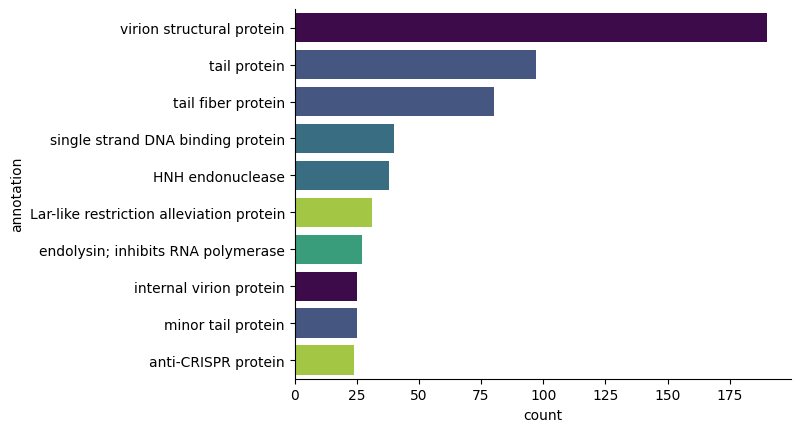

In [75]:
# let's represent this information visually - colors according to the same PHROG palette as in Notebook Code_annotation_background.ipynb
sns.barplot(data = annotations.sort_values("count", ascending = False)[0:10], y = "annotation", x = "count", hue = "annotation", palette =   
            {"virion structural protein" : "#440154", "tail protein" : "#3b528b", "tail fiber protein" : "#3b528b", 
             "single strand DNA binding protein" : "#2c728e", "HNH endonuclease": "#2c728e", "Lar-like restriction alleviation protein" : "#addc30", 
             "endolysin; inhibits RNA polymerase" : "#28ae80", "internal virion protein" : "#440154", "minor tail protein" : "#3b528b",
             "anti-CRISPR protein" : "#addc30"})
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig6", "top10annotation_phold_bah_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [76]:
# let's have a look at the annotations found - PDB BAH
annotations = pdb_ann_ta_match_bah_ann.groupby("best_ann_bah").count().reset_index()[["best_ann_bah", "protein"]]
annotations.rename(columns = {"best_ann_bah" : "annotation", "protein" : "count"}, inplace = True)
annotations.sort_values("count", ascending = False)[0:10]

,annotation,count
198,"Pseudomonas phage E217 neck (portal, head-to-t...",12
31,Cryo-EM Structure of the P74-26 Tail Tube,10
5,70S-PHIKZ014,10
166,Cyanophage Pam3 baseplate proteins,8
225,Structure of Clostridium botulinum prophage Ta...,8
292,VRR_NUC domain protein,7
258,Structure of the apo-state of the bacteriophag...,7
82,Crystal structure of Putative Oxygenase (YP_00...,7
1,2.1 Angstrom resolution crystal structure of u...,7
156,Crystal structure of the peptidyl-tRNA hydrola...,7


<Axes: xlabel='count', ylabel='annotation'>

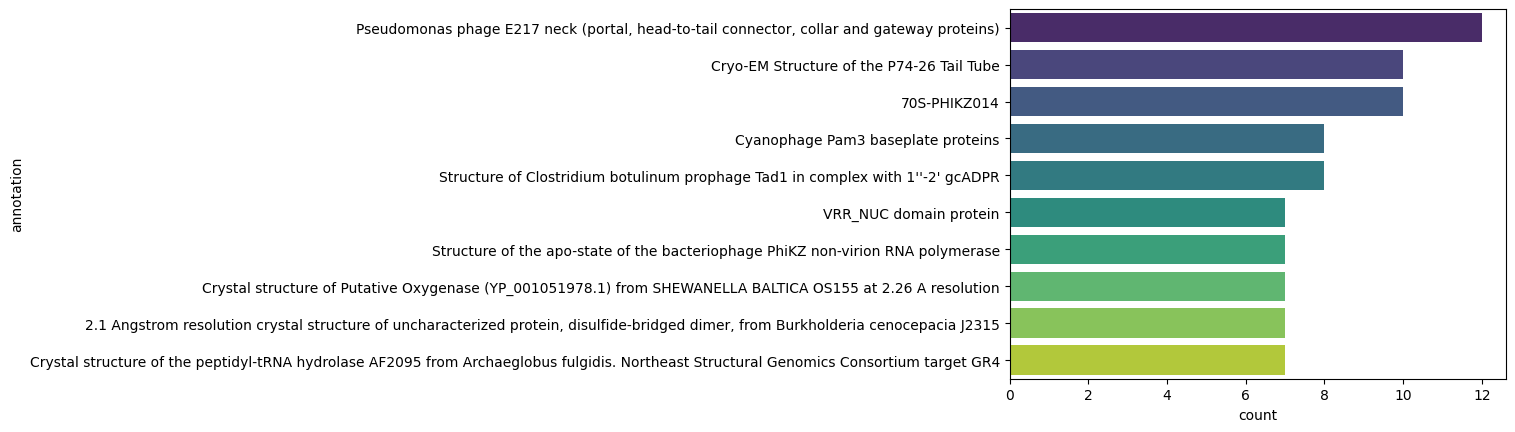

In [77]:
# let's represent this information visually
sns.barplot(data = annotations.sort_values("count", ascending = False)[0:10], y = "annotation", x = "count", hue = "annotation", palette = "viridis")

In [78]:
# let's have a look at the annotations found - AF BAH
annotations = afdb_ann_ta_match_bah_ann.groupby("best_ann_bah").count().reset_index()[["best_ann_bah", "protein"]]
annotations.rename(columns = {"best_ann_bah" : "annotation", "protein" : "count"}, inplace = True)
annotations.sort_values("count", ascending = False)[0:10]

,annotation,count
175,DUF4326 domain-containing protein,24
651,Virion structural protein,22
189,DUF5664 domain-containing protein,21
202,Ead/Ea22-like family protein,19
215,Fe2OG dioxygenase domain-containing protein,15
459,Protein of uncharacterized function (DUF3268),15
221,FluMu_N domain-containing protein,15
617,Transposase,14
503,Putative structural protein,13
416,Phage tail protein,13


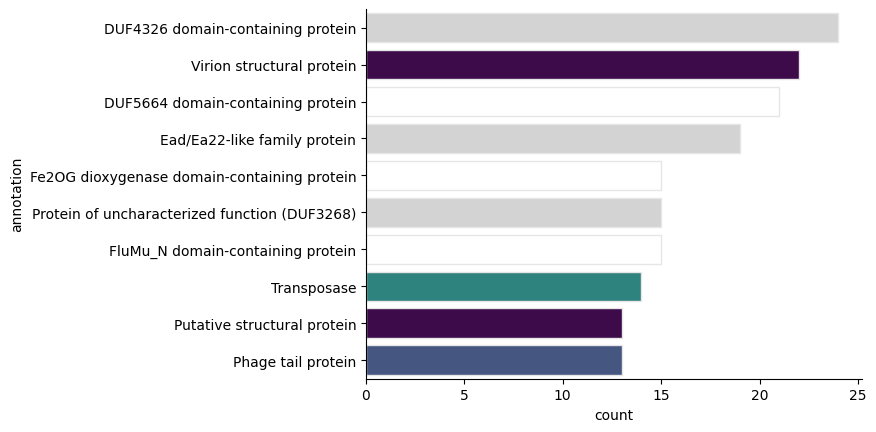

In [79]:
# let's represent this information visually
sns.barplot(data = annotations.sort_values("count", ascending = False)[0:10], y = "annotation", x = "count", hue = "annotation", palette = {
    "DUF4326 domain-containing protein" : "#d3d3d3", "Virion structural protein" : "#440154", "DUF5664 domain-containing protein" : "#ffffff",
    "Ead/Ea22-like family protein" : "#d3d3d3", "Fe2OG dioxygenase domain-containing protein" : "#ffffff", 
    "Protein of uncharacterized function (DUF3268)" : "#d3d3d3", "FluMu_N domain-containing protein" : "#ffffff",
    "Transposase" : "#21918c", "Putative structural protein" : "#440154", "Phage tail protein" : "#3b528b"}, linewidth = 1, edgecolor = "0.9" )
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig6", "top10annotation_af_bah_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

#### Goal 8 : Implement a three tiered best annotated hit annotation method, and assess whether it improves annotations from the AlphaFold database.

Clearly, the AlphaFold database still contains many annotations of 'low information': the most common annotations contain multiple DUF-domain containing proteins. Let's see if we can improve annotation quality, but adding a third level of annotation quality, beyond the binary annotated/unannotated. But first, let's check how many of the current annotations could be seen as of 'low informative'.

In [80]:
# set of filters to identify low informative annotations
low_af_search = [r"duf[0-9]+", "br0599"] 
low_af_match = [r"uncharacterized (mitochondrial )?protein ((xf_1581/xf_1686)|(atmg00810-like))",
                  r"uncharacterized( membrane)? protein ([\w+]+ )?\((upf)[\d+]+( family\))", r"cson[\d+]+ protein", 
                  "putative phage-related exported protein",
                  r"((hypothetical|predicted|putative) )?(conserved )?((pro)?phage )?(cytosolic|membrane|secreted|exported|cytoplasmic)( associated)?( phage)? protein(, putative)?"
                 ]

In [81]:
# function to test whether an annotation is to be considered low informative
def is_low_af(descr):
    low_label = False
    for filter_descr_s in low_af_search:
        if re.search(filter_descr_s, descr.strip().lower()) != None:
            low_label = True
    for filter_descr_m in low_af_match:
        if re.fullmatch(filter_descr_m, descr.strip().lower()) != None:
            low_label = True
    return low_label

In [82]:
# investigating the number of low informative annotations
afdb_ann_ta_match_bah_ann["low_inf"] = afdb_ann_ta_match_bah_ann.apply(lambda row: is_low_af(row["best_ann_bah"]),axis=1)

C:\Users\hanne\AppData\Local\Temp\ipykernel_13196\1527752821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afdb_ann_ta_match_bah_ann["low_inf"] = afdb_ann_ta_match_bah_ann.apply(lambda row: is_low_af(row["best_ann_bah"]),axis=1)


In [83]:
# printing some statistics
num_low_inf = len(afdb_ann_ta_match_bah_ann[afdb_ann_ta_match_bah_ann["low_inf"] == True])
num_high_inf = len(afdb_ann_ta_match_bah_ann[afdb_ann_ta_match_bah_ann["low_inf"] == False])
per_low_inf = "{:.2f}".format(num_low_inf*100/(num_low_inf+num_high_inf))
per_high_inf = "{:.2f}".format(num_high_inf*100/(num_low_inf+num_high_inf))
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_match_bah_ann} ({per_afdb_ann_ta_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_high_inf} ({per_high_inf}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_low_inf} ({per_low_inf}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_match_bah_unann + num_afdb_ann_ta_nomatch} ({num_afdb_ann_ta_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 1492 (43.15% of all those with matches, 19.51% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 1180 (79.09% of all annotations)
        Number of clusters with lowly informative annotations: 312 (20.91% of all annotations) 
    Number of clusters without annotations: 6154 (4188 due to no matches)


Let's now see if we can improve this rate if we use the three tiers during the annotation process.

In [84]:
# now let's write a function to loop over a list of entries, and look for the best annotation
def find_best_annotation_foldseek_af50m_tt(dataframe):
    annotation_found = False
    low_annotation_found = False
    low_list = list()
    for i in range(0, len(dataframe)):
        target = dataframe.at[i, "target"]
        descr = af50mid_descr_db.get(target)
        # get top annotation that is not a hypothetical or low informative annotation
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == False):
            annotation_found = True
            best_ann = descr
            break
        # accumulate low informative annotations
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == True):
            low_annotation_found = True
            low_list.append(descr)
    # if all annotations are hypothetical or low information, the annotation_found flag remains False
    if annotation_found == False:
        # if we have a low information annotation, we prefer this one (if multiple, the one rated highest)
        if low_annotation_found == True:
            best_ann = low_list[0]
        # if we do not have a low informative annotation, we take the highest ranked annotation
        else:
            best_ann = af50mid_descr_db.get(dataframe.at[0, "target"])
    return best_ann, annotation_found, low_annotation_found

In [ ]:
# writing results to file for inspection
file = open(os.path.join(one_hit_dir, "best_annotated_hit_threetiers_annotations.tsv"), "w")
file.write(f"protein\tpdb/af50m\tempty\tbest_ann\tannotation_found\tlow_information\n")
for batch, protein_set in dict_batch_comp.items():
    for protein in protein_set:
        pdb_fil, af50m_fil = read_foldseek_protein(batch, protein)
        if af50m_fil.empty:
            file.write(f"{protein}\taf50m\tTrue\tNA\tNA\tNA\n")
        if not af50m_fil.empty:
            af50m_fil = af50m_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found, low_annotation_found = find_best_annotation_foldseek_af50m_tt(af50m_fil)
            file.write(f"{protein}\taf50m\tFalse\t{best_ann}\t{annotation_found}\t{low_annotation_found}\n") 
file.close()

In [85]:
# reading results
afdb_ann_tt = pd.read_csv(os.path.join(one_hit_dir, "best_annotated_hit_threetiers_annotations.tsv"), sep = "\t")
    # adding information on Pharokka annotation
afdb_ann_tt["pharokka_ann"] = False
afdb_ann_tt.loc[afdb_ann_tt["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True

In [86]:
# AlphaFold database statistics
afdb_ann_ta_tt = afdb_ann_tt[afdb_ann_tt["pharokka_ann"] == False]
afdb_ann_ta_tt_match = afdb_ann_ta_tt[afdb_ann_ta_tt["empty"] == False]
afdb_ann_ta_tt_match_bah_ann = afdb_ann_ta_tt_match[~((afdb_ann_ta_tt_match["annotation_found"] == False) & (afdb_ann_ta_tt_match["low_information"] == False))]
afdb_ann_ta_tt_match_bah_ann_hi = afdb_ann_ta_tt_match[afdb_ann_ta_tt_match["annotation_found"] == True]
afdb_ann_ta_tt_match_bah_ann_li = afdb_ann_ta_tt_match[(afdb_ann_ta_tt_match["annotation_found"] == False) & (afdb_ann_ta_tt_match["low_information"] == True)]
afdb_ann_ta_tt_match_bah_unann = afdb_ann_ta_tt_match[(afdb_ann_ta_tt_match["annotation_found"] == False) & (afdb_ann_ta_tt_match["low_information"] == False)]
    # number of truly unannotated clusters with no match against AlphaFold database
num_afdb_ann_ta_tt_nomatch = len(afdb_ann_ta_tt[afdb_ann_ta_tt["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against AlphaFold database
per_afdb_ann_ta_tt_nomatch = "{:.2f}".format(num_afdb_ann_ta_tt_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_afdb_ann_ta_tt_match_bah_ann = len(afdb_ann_ta_tt_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_afdb_ann_ta_tt_bah_ann = "{:.2f}".format(num_afdb_ann_ta_tt_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_ta_tt_match_bah_ann = "{:.2f}".format(num_afdb_ann_ta_tt_match_bah_ann*100/(num_tba_ta-num_afdb_ann_ta_tt_nomatch)) 
    # of the truly unannotated clusters with annotated matches, how many are high informative annotations
num_afdb_ann_ta_tt_match_bah_ann_hi = len(afdb_ann_ta_tt_match_bah_ann_hi)
    # of the truly unannotated clusters with annotated matches, how many are low informative annotations
num_afdb_ann_ta_tt_match_bah_ann_li = len(afdb_ann_ta_tt_match_bah_ann_li)
    # of the truly unannotated clusters with annotated matches, which percentage are high informative annotations
per_afdb_ann_ta_tt_match_bah_ann_hi = "{:.2f}".format(num_afdb_ann_ta_tt_match_bah_ann_hi*100/(num_afdb_ann_ta_tt_match_bah_ann_li+num_afdb_ann_ta_tt_match_bah_ann_hi))
    # of the truly unannotated clusters with annotated matches, which percentage are low informative annotations
per_afdb_ann_ta_tt_match_bah_ann_li = "{:.2f}".format(num_afdb_ann_ta_tt_match_bah_ann_li*100/(num_afdb_ann_ta_tt_match_bah_ann_li+num_afdb_ann_ta_tt_match_bah_ann_hi))
    # number of truly unannotated clusters with unannotated match (BAH method)
num_afdb_ann_ta_tt_match_bah_unann = len(afdb_ann_ta_tt_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_tt_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_tt_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_tt_match_bah_ann} ({per_afdb_ann_ta_tt_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_tt_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_afdb_ann_ta_tt_match_bah_ann_hi} ({per_afdb_ann_ta_tt_match_bah_ann_hi}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_afdb_ann_ta_tt_match_bah_ann_li} ({per_afdb_ann_ta_tt_match_bah_ann_li}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_tt_match_bah_unann + num_afdb_ann_ta_tt_nomatch} ({num_afdb_ann_ta_tt_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 1492 (43.15% of all those with matches, 19.51% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 1379 (92.43% of all annotations)
        Number of clusters with lowly informative annotations: 113 (7.57% of all annotations) 
    Number of clusters without annotations: 6154 (4188 due to no matches)


Indeed, the number of low informative annotations can be drastically reduced! Let's represent this information visually:

In [87]:
# let's have a look at the annotations found - AF BAH
annotations = afdb_ann_ta_tt_match_bah_ann.groupby("best_ann").count().reset_index()[["best_ann", "protein"]]
annotations.rename(columns = {"best_ann" : "annotation", "protein" : "count"}, inplace = True)
annotations.sort_values("count", ascending = False)[0:10]

,annotation,count
658,Virion structural protein,22
178,Ead/Ea22-like family protein,21
167,DUF5664 domain-containing protein,18
198,FluMu_N domain-containing protein,15
192,Fe2OG dioxygenase domain-containing protein,15
505,Putative structural protein,14
73,Burkholderia phage Bcep781 gp05,14
632,Transposase,14
411,Phage tail protein,13
318,Minor capsid protein,11


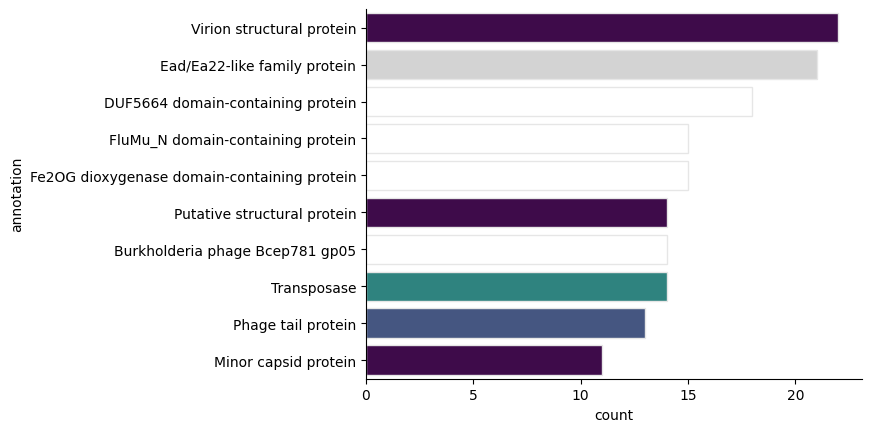

In [88]:
# let's represent this information visually
sns.barplot(data = annotations.sort_values("count", ascending = False)[0:10], y = "annotation", x = "count", hue = "annotation", palette = {
    "Virion structural protein" : "#440154", "Ead/Ea22-like family protein" : "#d3d3d3", "DUF5664 domain-containing protein" : "#ffffff",
    "FluMu_N domain-containing protein" : "#ffffff", "Fe2OG dioxygenase domain-containing protein" : "#ffffff", "Putative structural protein" : "#440154",
    "Burkholderia phage Bcep781 gp05" : "#ffffff", "Transposase" : "#21918c", "Phage tail protein" : "#3b528b", "Minor capsid protein" : "#440154"}, 
    linewidth = 1, edgecolor = "0.9" )
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig6", "top10annotation_af_bah_tt_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

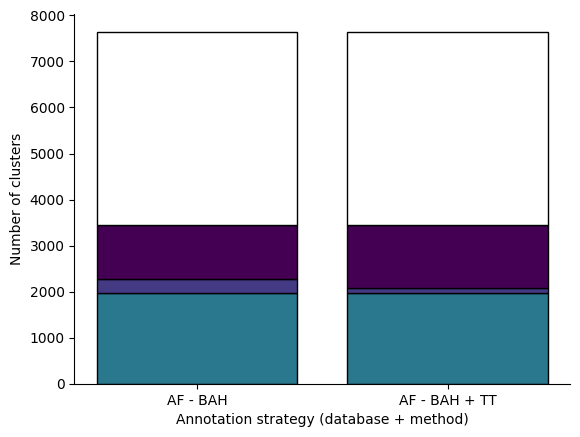

In [89]:
# now let's do a stacked bar chart to show the change in low informative annotations
# creating data dicts
afdb_bah_data = {"no match" : len(afdb_ann_ta[afdb_ann_ta["empty"] == True]) , 
               "highly informative annotation": num_high_inf, 
               "lowly informative annotation": num_low_inf, 
               "unannotated match": len(afdb_ann_ta_match_bah_unann)}
afdb_bah_tt_data = {"no match" : num_afdb_ann_ta_tt_nomatch, 
               "highly informative annotation": num_afdb_ann_ta_tt_match_bah_ann_hi, 
               "lowly informative annotation": num_afdb_ann_ta_tt_match_bah_ann_li, 
               "unannotated match": num_afdb_ann_ta_tt_match_bah_unann}
# put data in long format in a dataframe
data_plot = pd.DataFrame({"Annotation status": list(afdb_bah_data.keys()) + list(afdb_bah_tt_data.keys()),
                    "Dataset": ["AF - BAH"] * len(afdb_bah_data.items()) + ["AF - BAH + TT"] * len(afdb_bah_tt_data.items()),
                    "Number of clusters": list(afdb_bah_data.values()) + list(afdb_bah_tt_data.values())})
# one liner to create a stacked bar chart
ax = sns.histplot(data_plot, x = "Dataset", hue = "Annotation status" , weights = "Number of clusters", multiple = "stack", palette = {
                  "no match" : "#ffff", "unannotated match" : "#2a788e", "highly informative annotation" : "#440154", "lowly informative annotation" : "#443983"}, 
                  shrink = 0.8, alpha = 1, legend = False)
ax.set_ylabel("Number of clusters")
ax.set_xlabel("Annotation strategy (database + method)")
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig6", "distribution_informativeness_bah_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

#### Goal 9 : Implement a three tiered best annotated hit annotation method, and assess whether it improves annotations fetched through UniProt.

Clearly, the AlphaFold database annotations could be improved when using a three tiered classification scheme. Does the same hold for the UniProt annotations for the PDB and AlphaFold database? 

##### Assessing the amount of low informative annotations present in the two tiered system

In [90]:
# investigating the number of low informative annotations - PDB database
pdb_ann_ta_up_match_bah_ann["low_inf"] = pdb_ann_ta_up_match_bah_ann.apply(lambda row: is_low_af(row["best_ann"]),axis=1)

C:\Users\hanne\AppData\Local\Temp\ipykernel_13196\3550353553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdb_ann_ta_up_match_bah_ann["low_inf"] = pdb_ann_ta_up_match_bah_ann.apply(lambda row: is_low_af(row["best_ann"]),axis=1)


In [91]:
# printing some statistics
num_low_inf_pdb_up = len(pdb_ann_ta_up_match_bah_ann[pdb_ann_ta_up_match_bah_ann["low_inf"] == True])
num_high_inf_pdb_up = len(pdb_ann_ta_up_match_bah_ann[pdb_ann_ta_up_match_bah_ann["low_inf"] == False])
per_low_inf_pdb_up = "{:.2f}".format(num_low_inf_pdb_up*100/(num_low_inf_pdb_up+num_high_inf_pdb_up))
per_high_inf_pdb_up = "{:.2f}".format(num_high_inf_pdb_up*100/(num_low_inf_pdb_up+num_high_inf_pdb_up))
print(f"Statistics of annotation using the PDB:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_ta-num_pdb_ann_ta_up_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_ta_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_ta_up_match_bah_ann} ({per_pdb_ann_ta_up_match_bah_ann}% of all those with matches, {per_pdb_ann_ta_up_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_high_inf_pdb_up} ({per_high_inf_pdb_up}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_low_inf_pdb_up} ({per_low_inf_pdb_up}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_pdb_ann_ta_up_match_bah_unann + num_pdb_ann_ta_up_nomatch} ({num_pdb_ann_ta_up_nomatch} due to no matches)")

Statistics of annotation using the PDB:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 508
    Number of clusters without matches: 7138
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 482 (94.88% of all those with matches, 6.30% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 463 (96.06% of all annotations)
        Number of clusters with lowly informative annotations: 19 (3.94% of all annotations) 
    Number of clusters without annotations: 7164 (7138 due to no matches)


In [92]:
# investigating the number of low informative annotations - AlphaFold database
afdb_ann_ta_up_match_bah_ann["low_inf"] = afdb_ann_ta_up_match_bah_ann.apply(lambda row: is_low_af(row["best_ann"]),axis=1)

C:\Users\hanne\AppData\Local\Temp\ipykernel_13196\3018838957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afdb_ann_ta_up_match_bah_ann["low_inf"] = afdb_ann_ta_up_match_bah_ann.apply(lambda row: is_low_af(row["best_ann"]),axis=1)


In [93]:
# printing some statistics
num_low_inf_afdb_up = len(afdb_ann_ta_up_match_bah_ann[afdb_ann_ta_up_match_bah_ann["low_inf"] == True])
num_high_inf_afdb_up = len(afdb_ann_ta_up_match_bah_ann[afdb_ann_ta_up_match_bah_ann["low_inf"] == False])
per_low_inf_afdb_up = "{:.2f}".format(num_low_inf_afdb_up*100/(num_low_inf_afdb_up+num_high_inf_afdb_up))
per_high_inf_afdb_up = "{:.2f}".format(num_high_inf_afdb_up*100/(num_low_inf_afdb_up+num_high_inf_afdb_up))
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_up_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_up_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_up_match_bah_ann} ({per_afdb_ann_ta_up_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_up_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_high_inf_afdb_up} ({per_high_inf_afdb_up}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_low_inf_afdb_up} ({per_low_inf_afdb_up}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_up_match_bah_unann + num_afdb_ann_ta_up_nomatch} ({num_afdb_ann_ta_up_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 2656 (76.81% of all those with matches, 34.74% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 2100 (79.07% of all annotations)
        Number of clusters with lowly informative annotations: 556 (20.93% of all annotations) 
    Number of clusters without annotations: 4990 (4188 due to no matches)


##### Applying a three tiered classification scheme during best annotated hit annotation

In [94]:
# updated functions - AlphaFold database searches

# a function that extracts the best annotation from the list of annotations obtained from UniParc
def extract_best_uniparc_tt(entries_list):
    annotation_found = False
    low_annotation_found = False
    low_list = list()
    for descr in entries_list:
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == False):
            annotation_found = True
            best_ann = descr
            break
        # accumulate low informative annotations
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == True):
            low_annotation_found = True
            low_list.append(descr)
    if annotation_found == False:
        # if we have a low informative annotation, we prefer this one (if multiple, the one rated highest)
        if low_annotation_found == True:
            best_ann = low_list[0]
        # if we do not have a low informative annotation, we take the highest ranked annotation
        else:
            best_ann = entries_list[0]
    return best_ann

def find_best_annotation_foldseek_af50m_up_tt(dataframe):
    annotation_found = False
    low_annotation_found = False
    low_index_list = list()
    for i in range(0, len(dataframe)):
        uniprot_id = get_UniProtID_from_target(dataframe.at[i, "target"])
        descr = get_function_from_UniProtID(uniprot_id)
        # checking if UniProt entry has been fetched
        if descr == "[UNIPROT RECORD NOT YET FETCHED]":
            continue
        # checking if entry contains information from UniParc:
        uniparc_used = False
        if uniparc_needed(descr):
            uniparc_used = True
            if uniparc_fail(descr) == False:
                descr = extract_best_uniparc_tt(uniparc2list(descr))
            if uniparc_fail(descr) == True:
                continue
        # checking whether (best UniParc) description is annotated
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == False):
            annotation_found = True
            best_ann_index = i
            break
        # accumulate low informative annotations
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == True):
            low_annotation_found = True
            low_index_list.append(i)
    # if all annotations are hypothetical or low informative, the annotation_found flag remains False
    if annotation_found == False:
        # if we have a low informative annotation, we prefer this one (if multiple, the one rated highest)
        if low_annotation_found == True:
            best_ann_index = low_index_list[0]
        # if we do not have a low informative annotation, we take the highest ranked annotation
        else:
            best_ann_index = 0
    best_ann = get_function_from_UniProtID(get_UniProtID_from_target(dataframe.at[best_ann_index, "target"]))
    return best_ann, annotation_found, low_annotation_found


In [95]:
# updated functions - PDB database

# a function that extracts the best annotation from the list of annotations obtained from PDB
def extract_best_pdb_tt(entries_list):
    annotation_found = False
    low_annotation_found = False
    low_list = list()
    for descr in entries_list:
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == False):
            annotation_found = True
            best_ann = descr
            break
        # accumulate low informative annotations
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == True):
            low_annotation_found = True
            low_list.append(descr)
    if annotation_found == False:
        # if we have a low informative annotation, we prefer this one (if multiple, the one rated highest)
        if low_annotation_found == True:
            best_ann = low_list[0]
        # if we do not have a low informative annotation, we take the highest ranked annotation
        else:
            best_ann = entries_list[0]
    return best_ann

# actual method for parsing
def find_best_annotation_foldseek_pdb_up_tt(dataframe):
    annotation_found = False
    low_annotation_found = False
    low_index_list = list()
    for i in range(0, len(dataframe)):
        pdb_id, chain = get_PDBid_chain_from_target(dataframe.at[i,"target"])
        full_descr = get_function_from_PDB(pdb_id, chain)
        if re.fullmatch(r"\[(PDB|UNIPROT) RECORD NOT YET FETCHED\]", full_descr) != None:
            continue
        if full_descr == "WARNING This PDB ID is obsolete, hence, no information could be fetched":
            continue
        if full_descr == "WARNING No UniProt ID was linked to this PDB entry, hence, no information could be fetched":
            continue
        descr = extract_best_pdb_tt(pdbdescr2list(full_descr))
        # checking if entry contains information from UniParc:
        uniparc_used = False
        if uniparc_needed(descr):
            uniparc_used = True
            if uniparc_fail(descr) == False:
                descr = extract_best_uniparc_tt(uniparc2list(descr))
            if uniparc_fail(descr) == True:
                continue
        # how will we deal with uniparc lists though
        # get top annotation that is not a hypothetical or low informative annotation
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == False):
            annotation_found = True
            best_ann_index = i
            break
        # accumulate low informative annotations
        if (is_hypothetical_af(descr) == False) and (is_low_af(descr) == True):
            low_annotation_found = True
            low_index_list.append(i)
    # if all annotations are hypothetical or low informative, the annotation_found flag remains False
    if annotation_found == False:
        # if we have a low informative annotation, we prefer this one (if multiple, the one rated highest)
        if low_annotation_found == True:
            best_ann_index = low_index_list[0]
        # if we do not have a low informative annotation, we take the highest ranked annotation
        else:
            best_ann_index = 0
    pdb_id, chain = get_PDBid_chain_from_target(dataframe.at[best_ann_index,"target"])
    best_ann = get_function_from_PDB(pdb_id, chain)
    return best_ann, annotation_found, low_annotation_found

In [ ]:
# writing results to file for inspection
file = open(os.path.join(one_hit_dir, "best_annotated_hit_uniprot_threetiers_annotations.tsv"), "a")
file.write(f"protein\tpdb/af50m\tempty\tbest_ann\tannotation_found\tlow_information\n")
for batch, protein_set in dict_batch_comp.items():
    for protein in protein_set:
        pdb_fil, af50m_fil = read_foldseek_protein(batch, protein)
        if pdb_fil.empty:
            file.write(f"{protein}\tpdb\tTrue\tNA\tNA\tNA\n")
        if not pdb_fil.empty:
            pdb_fil = pdb_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found, low_annotation_found = find_best_annotation_foldseek_pdb_up_tt(pdb_fil)
            file.write(f"{protein}\tpdb\tFalse\t{best_ann}\t{annotation_found}\t{low_annotation_found}\n")
        if af50m_fil.empty:
            file.write(f"{protein}\taf50m\tTrue\tNA\tNA\tNA\n")
        if not af50m_fil.empty:
            af50m_fil = af50m_fil.sort_values("bits", ascending = False)
            best_ann, annotation_found, low_annotation_found = find_best_annotation_foldseek_af50m_up_tt(af50m_fil)
            file.write(f"{protein}\taf50m\tFalse\t{best_ann}\t{annotation_found}\t{low_annotation_found}\n") 
file.close()

##### Assessing the amount of low informative annotations present in the three tiered system

In [96]:
# reading in the results
best_ann_hit_up_tt_df = pd.read_csv(os.path.join(one_hit_dir, "best_annotated_hit_uniprot_threetiers_annotations.tsv"), sep = "\t")
    # adding information on Pharokka annotation
best_ann_hit_up_tt_df["pharokka_ann"] = False
best_ann_hit_up_tt_df.loc[best_ann_hit_up_tt_df["protein"].isin(ncbi_id_ann), "pharokka_ann"] = True

In [97]:
# splitting PDB from AlphaFold database results
pdb_ann_up_tt = best_ann_hit_up_tt_df[best_ann_hit_up_tt_df["pdb/af50m"] == "pdb"]
afdb_ann_up_tt = best_ann_hit_up_tt_df[best_ann_hit_up_tt_df["pdb/af50m"] == "af50m"]

In [98]:
# PDB statistics - truly unannotated subset
pdb_ann_ta_up_tt = pdb_ann_up_tt[pdb_ann_up_tt["pharokka_ann"] == False]
pdb_ann_ta_up_tt_match = pdb_ann_ta_up_tt[pdb_ann_ta_up_tt["empty"] == False]
pdb_ann_ta_up_tt_match_bah_ann = pdb_ann_ta_up_tt_match[~((pdb_ann_ta_up_tt_match["annotation_found"] == False) & (pdb_ann_ta_up_tt_match["low_information"] == False))]
pdb_ann_ta_up_tt_match_bah_ann_hi = pdb_ann_ta_up_tt_match[pdb_ann_ta_up_tt_match["annotation_found"] == True]
pdb_ann_ta_up_tt_match_bah_ann_li = pdb_ann_ta_up_tt_match[(pdb_ann_ta_up_tt_match["annotation_found"] == False) & (pdb_ann_ta_up_tt_match["low_information"] == True)]
pdb_ann_ta_up_tt_match_bah_unann = pdb_ann_ta_up_tt_match[(pdb_ann_ta_up_tt_match["annotation_found"] == False) & (pdb_ann_ta_up_tt_match["low_information"] == False)]
    # number of truly unannotated clusters with no match against PDB
num_pdb_ann_ta_up_tt_nomatch = len(pdb_ann_ta_up_tt[pdb_ann_ta_up_tt["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against PDB
per_pdb_ann_ta_up_tt_nomatch = "{:.2f}".format(num_pdb_ann_ta_up_tt_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_pdb_ann_ta_up_tt_match_bah_ann = len(pdb_ann_ta_up_tt_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_pdb_ann_ta_up_tt_bah_ann = "{:.2f}".format(num_pdb_ann_ta_up_tt_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_pdb_ann_ta_up_tt_match_bah_ann = "{:.2f}".format(num_pdb_ann_ta_up_tt_match_bah_ann*100/(num_tba_ta-num_pdb_ann_ta_up_tt_nomatch)) 
    # of the truly unannotated clusters with annotated matches, how many are high informative annotations
num_pdb_ann_ta_up_tt_match_bah_ann_hi = len(pdb_ann_ta_up_tt_match_bah_ann_hi)
    # of the truly unannotated clusters with annotated matches, how many are low informative annotations
num_pdb_ann_ta_up_tt_match_bah_ann_li = len(pdb_ann_ta_up_tt_match_bah_ann_li)
    # of the truly unannotated clusters with annotated matches, which percentage are high informative annotations
per_pdb_ann_ta_up_tt_match_bah_ann_hi = "{:.2f}".format(num_pdb_ann_ta_up_tt_match_bah_ann_hi*100/(num_pdb_ann_ta_up_tt_match_bah_ann_li+num_pdb_ann_ta_up_tt_match_bah_ann_hi))
    # of the truly unannotated clusters with annotated matches, which percentage are low informative annotations
per_pdb_ann_ta_up_tt_match_bah_ann_li = "{:.2f}".format(num_pdb_ann_ta_up_tt_match_bah_ann_li*100/(num_pdb_ann_ta_up_tt_match_bah_ann_li+num_pdb_ann_ta_up_tt_match_bah_ann_hi))
    # number of truly unannotated clusters with unannotated match (BAH method)
num_pdb_ann_ta_up_tt_match_bah_unann = len(pdb_ann_ta_up_tt_match_bah_unann)  
print(f"Statistics of annotation using the PDB:")
print(f"------------------------------------------------")
print(f"Matches against the PDB:")
print(f"    Number of clusters with matches: {num_tba_ta-num_pdb_ann_ta_up_tt_nomatch}")
print(f"    Number of clusters without matches: {num_pdb_ann_ta_up_tt_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_pdb_ann_ta_up_tt_match_bah_ann} ({per_pdb_ann_ta_up_tt_match_bah_ann}% of all those with matches, {per_pdb_ann_ta_up_tt_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_pdb_ann_ta_up_tt_match_bah_ann_hi} ({per_pdb_ann_ta_up_tt_match_bah_ann_hi}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_pdb_ann_ta_up_tt_match_bah_ann_li} ({per_pdb_ann_ta_up_tt_match_bah_ann_li}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_pdb_ann_ta_up_tt_match_bah_unann + num_pdb_ann_ta_up_tt_nomatch} ({num_pdb_ann_ta_up_tt_nomatch} due to no matches)")

Statistics of annotation using the PDB:
------------------------------------------------
Matches against the PDB:
    Number of clusters with matches: 508
    Number of clusters without matches: 7138
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 482 (94.88% of all those with matches, 6.30% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 465 (96.47% of all annotations)
        Number of clusters with lowly informative annotations: 17 (3.53% of all annotations) 
    Number of clusters without annotations: 7164 (7138 due to no matches)


In [99]:
# AlphaFold database statistics - truly unannotated subset
afdb_ann_ta_up_tt = afdb_ann_up_tt[afdb_ann_up_tt["pharokka_ann"] == False]
afdb_ann_ta_up_tt_match = afdb_ann_ta_up_tt[afdb_ann_ta_up_tt["empty"] == False]
afdb_ann_ta_up_tt_match_bah_ann = afdb_ann_ta_up_tt_match[~((afdb_ann_ta_up_tt_match["annotation_found"] == False) & (afdb_ann_ta_up_tt_match["low_information"] == False))]
afdb_ann_ta_up_tt_match_bah_ann_hi = afdb_ann_ta_up_tt_match[afdb_ann_ta_up_tt_match["annotation_found"] == True]
afdb_ann_ta_up_tt_match_bah_ann_li = afdb_ann_ta_up_tt_match[(afdb_ann_ta_up_tt_match["annotation_found"] == False) & (afdb_ann_ta_up_tt_match["low_information"] == True)]
afdb_ann_ta_up_tt_match_bah_unann = afdb_ann_ta_up_tt_match[(afdb_ann_ta_up_tt_match["annotation_found"] == False) & (afdb_ann_ta_up_tt_match["low_information"] == False)]
    # number of truly unannotated clusters with no match against AlphaFold database
num_afdb_ann_ta_up_tt_nomatch = len(afdb_ann_ta_up_tt[afdb_ann_ta_up_tt["empty"] == True]) 
    # percentage of truly unannotated clusters with no match against AlphaFold database
per_afdb_ann_ta_up_tt_nomatch = "{:.2f}".format(num_afdb_ann_ta_up_tt_nomatch*100/num_tba_ta)
    # number of truly unannotated clusters with annotated match (BAH method)
num_afdb_ann_ta_up_tt_match_bah_ann = len(afdb_ann_ta_up_tt_match_bah_ann) 
    # of the truly unannotated clusters which percentage gets annotated using BAH
per_afdb_ann_ta_up_tt_bah_ann = "{:.2f}".format(num_afdb_ann_ta_up_tt_match_bah_ann*100/(num_tba_ta)) 
    # of the truly unannotated clusters with matches, which percentage gets annotated using BAH
per_afdb_ann_ta_up_tt_match_bah_ann = "{:.2f}".format(num_afdb_ann_ta_up_tt_match_bah_ann*100/(num_tba_ta-num_afdb_ann_ta_up_tt_nomatch)) 
    # of the truly unannotated clusters with annotated matches, how many are high informative annotations
num_afdb_ann_ta_up_tt_match_bah_ann_hi = len(afdb_ann_ta_up_tt_match_bah_ann_hi)
    # of the truly unannotated clusters with annotated matches, how many are low informative annotations
num_afdb_ann_ta_up_tt_match_bah_ann_li = len(afdb_ann_ta_up_tt_match_bah_ann_li)
    # of the truly unannotated clusters with annotated matches, which percentage are high informative annotations
per_afdb_ann_ta_up_tt_match_bah_ann_hi = "{:.2f}".format(num_afdb_ann_ta_up_tt_match_bah_ann_hi*100/(num_afdb_ann_ta_up_tt_match_bah_ann_li+num_afdb_ann_ta_up_tt_match_bah_ann_hi))
    # of the truly unannotated clusters with annotated matches, which percentage are low informative annotations
per_afdb_ann_ta_up_tt_match_bah_ann_li = "{:.2f}".format(num_afdb_ann_ta_up_tt_match_bah_ann_li*100/(num_afdb_ann_ta_up_tt_match_bah_ann_li+num_afdb_ann_ta_up_tt_match_bah_ann_hi))
    # number of truly unannotated clusters with unannotated match (BAH method)
num_afdb_ann_ta_up_tt_match_bah_unann = len(afdb_ann_ta_up_tt_match_bah_unann)  
print(f"Statistics of annotation using the AlphaFold database:")
print(f"------------------------------------------------")
print(f"Matches against the AlphaFold database:")
print(f"    Number of clusters with matches: {num_tba_ta-num_afdb_ann_ta_up_tt_nomatch}")
print(f"    Number of clusters without matches: {num_afdb_ann_ta_up_tt_nomatch}")
print(f"------------------------------------------------")
print(f"Best annotated hit annotation method:")
print(f"    Number of clusters with annotations: {num_afdb_ann_ta_up_tt_match_bah_ann} ({per_afdb_ann_ta_up_tt_match_bah_ann}% of all those with matches, {per_afdb_ann_ta_up_tt_bah_ann}% of all truly unannotated clusters)")
print(f"        Number of clusters with highly informative annotations: {num_afdb_ann_ta_up_tt_match_bah_ann_hi} ({per_afdb_ann_ta_up_tt_match_bah_ann_hi}% of all annotations)")
print(f"        Number of clusters with lowly informative annotations: {num_afdb_ann_ta_up_tt_match_bah_ann_li} ({per_afdb_ann_ta_up_tt_match_bah_ann_li}% of all annotations) ")
print(f"    Number of clusters without annotations: {num_afdb_ann_ta_up_tt_match_bah_unann + num_afdb_ann_ta_up_tt_nomatch} ({num_afdb_ann_ta_up_tt_nomatch} due to no matches)")

Statistics of annotation using the AlphaFold database:
------------------------------------------------
Matches against the AlphaFold database:
    Number of clusters with matches: 3458
    Number of clusters without matches: 4188
------------------------------------------------
Best annotated hit annotation method:
    Number of clusters with annotations: 2656 (76.81% of all those with matches, 34.74% of all truly unannotated clusters)
        Number of clusters with highly informative annotations: 2467 (92.88% of all annotations)
        Number of clusters with lowly informative annotations: 189 (7.12% of all annotations) 
    Number of clusters without annotations: 4990 (4188 due to no matches)
